In [15]:
# importing the libraries
import numpy as np
import peakutils
import syntheticdata
import threegaussians
import lorentzian
from peakutils.plot import plot as pplot
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import interpolate
from astropy.modeling import models, fitting

# Smoothing 1-- Savgol 

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    
    """Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.

    """
    
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [306]:
def savitzky_golay_smoothing(nm_array, timedelay, noise_coefficient,window_size,order):
    import numpy as np
    import scipy.fftpack
    from matplotlib import pyplot as plt
    %matplotlib inline
    
    """
    Notes
    -----   
    generates a denoise curve from the TA data
    Parameters
    ----------
        nm_array: wavelength array
        timedelay: time delay array
        noise_coefficient: the noise coefficients that user want to generate
    Returns
    -------
        a smoothing curve from the original noise curve   
    """
 
   # generate some noisy data from syntheticdata:
    np.random.seed(1729)
    y_noise = noise_coefficient * np.random.normal(size=nm_array.size)
    ydata = timedelay + y_noise
    yhat = savitzky_golay(ydata,window_size, order) # window size 51, polynomial order 3
    
    
   # plot the noise data curve and denoise curve
    plt.figure(figsize=(40,20))
    plt.subplot(211)
    plt.title('smoothening data VS noisy data', fontsize = 30, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.plot(nm_array,ydata,markersize = 20, label = 'noise data')
    plt.plot(nm_array,yhat, color='red',markersize = 20, label = 'smooth data')
    plt.legend()
    
    
    plt.subplot(212)
    plt.title('true data VS smoothing data', fontsize = 30, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.plot(nm_array,timedelay,markersize = 20, label = 'true data')
    plt.plot(nm_array,yhat, color='red',markersize = 20, label = 'smooth data')
    plt.legend()
    
    return yhat

## when window_size is extreme small...

In [313]:
def peak_finding(x,y):
    indexes = peakutils.indexes(y, thres=0, min_dist=310)
    print(indexes)
    print(x[indexes], y[indexes])
    plt.figure(figsize=(20,5))
    pplot(x, y, indexes)
    plt.title('First estimate', fontsize = 15, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 15, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 15, fontweight = 'bold')

### Let's call the window length M and N is the order of the polynomial.  One important thing to realize is that you use a polynomial of order N to approximate M data points. 
### Generally, if N+1=M then you do not smooth at all , so N is chosen considerably smaller than M to achieve some smoothing.

[100 450]
[ 950 1300] [1.00065625 0.3       ]
[101 423 732]
[ 951 1273 1582] [1.09790977 0.42648819 0.08323599]


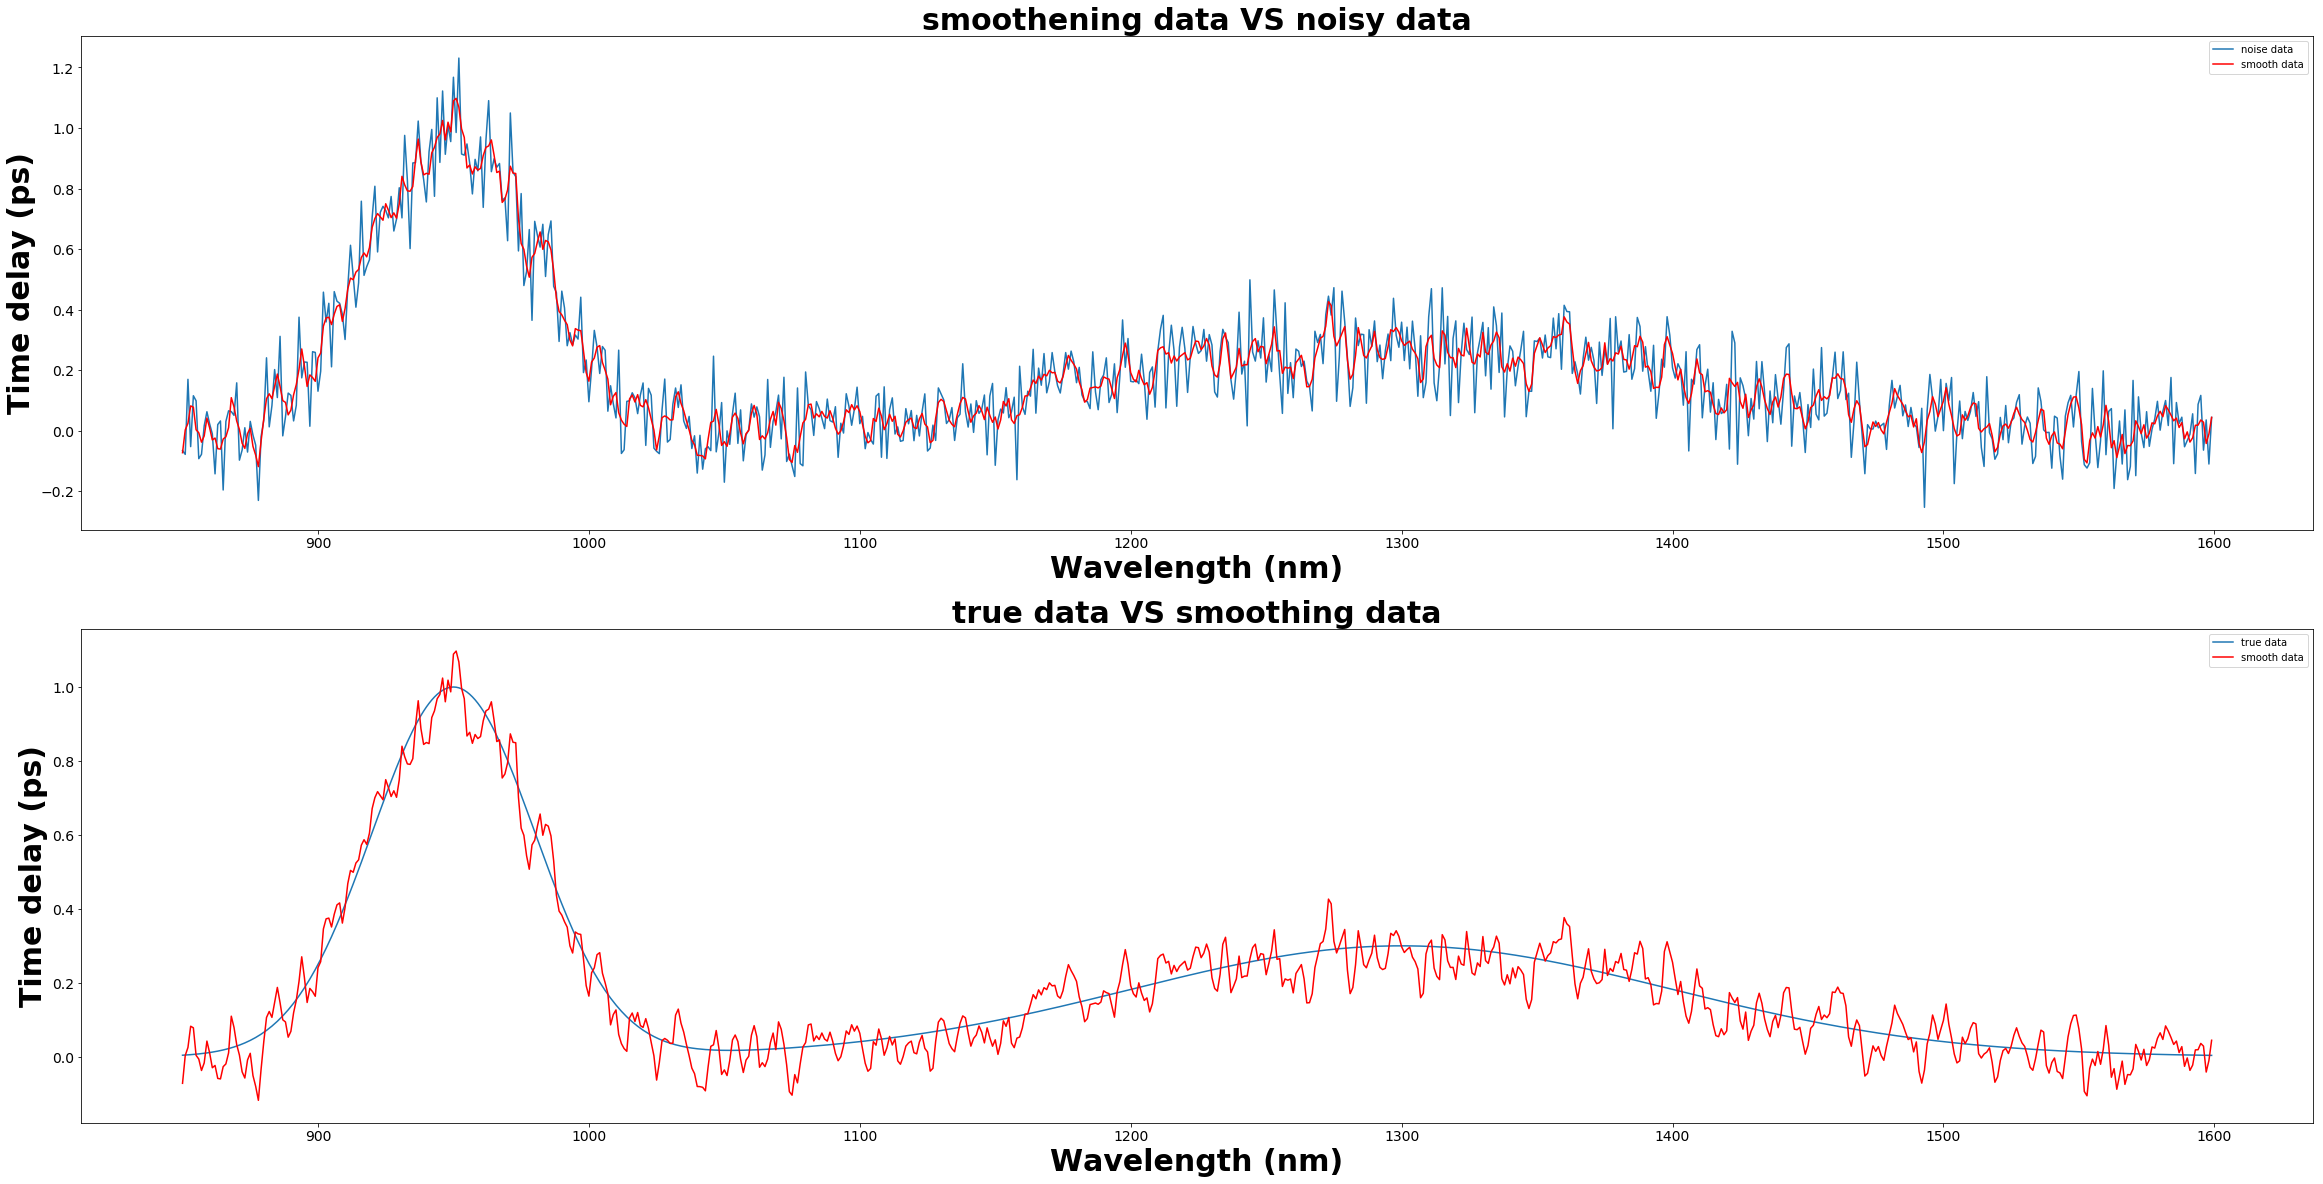

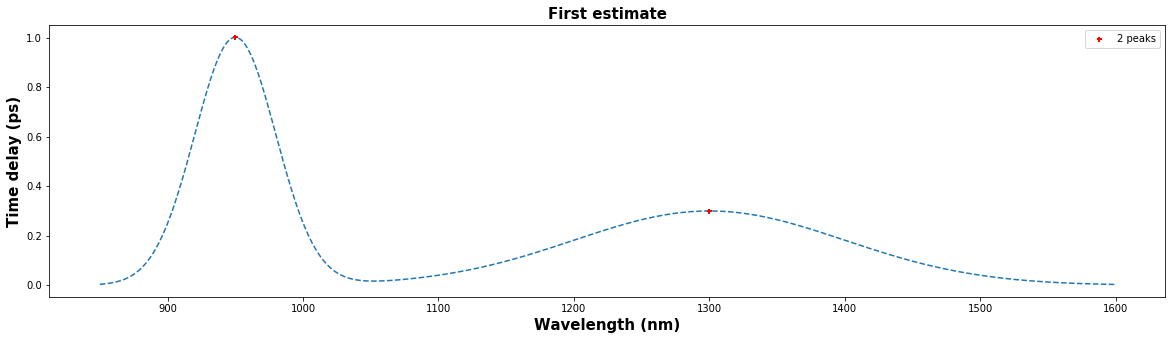

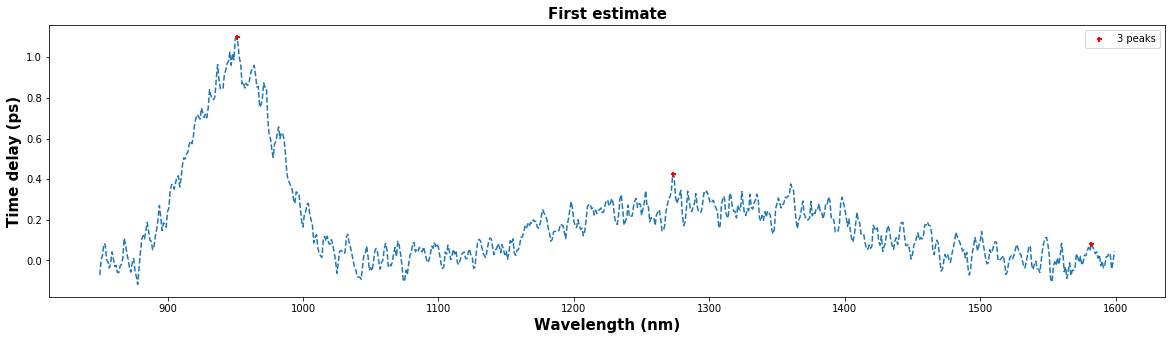

In [308]:
# return denoise curve of a two-gaussian mixture noise model
x = syntheticdata.nm
y = (syntheticdata.species_1 + syntheticdata.species_2)
noise_coefficient =0.1
yhat1=savitzky_golay_smoothing(x, y, noise_coefficient, 7, 3)
peak_finding(x,y)
peak_finding(x,yhat1)

## when window_size is extrme big...

[100 450]
[ 950 1300] [1.00065625 0.3       ]
[171 473]
[1021 1323] [0.33653131 0.2238571 ]


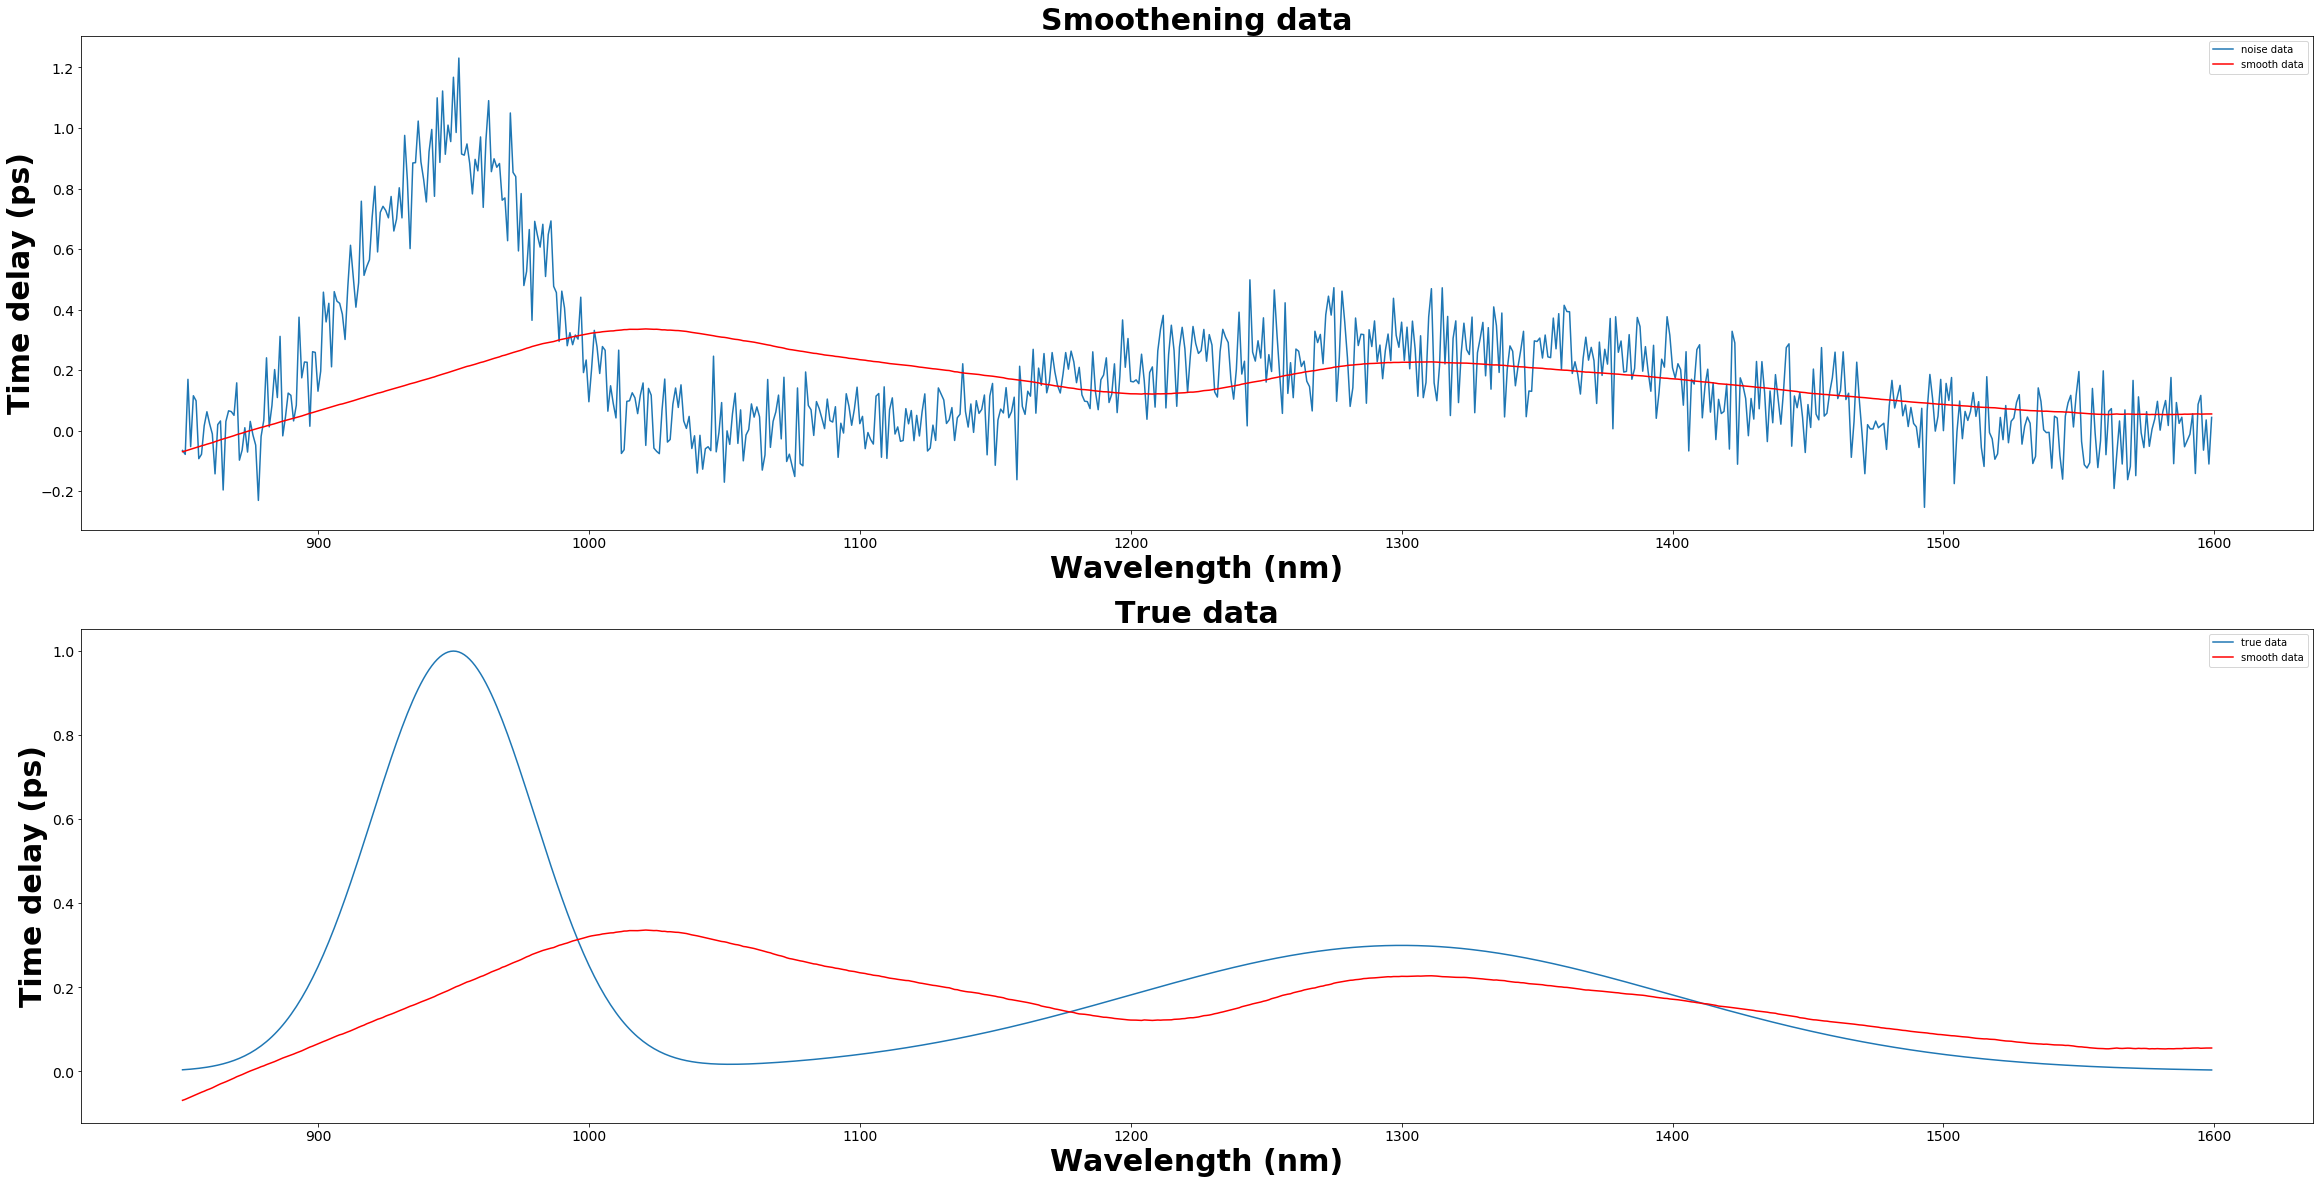

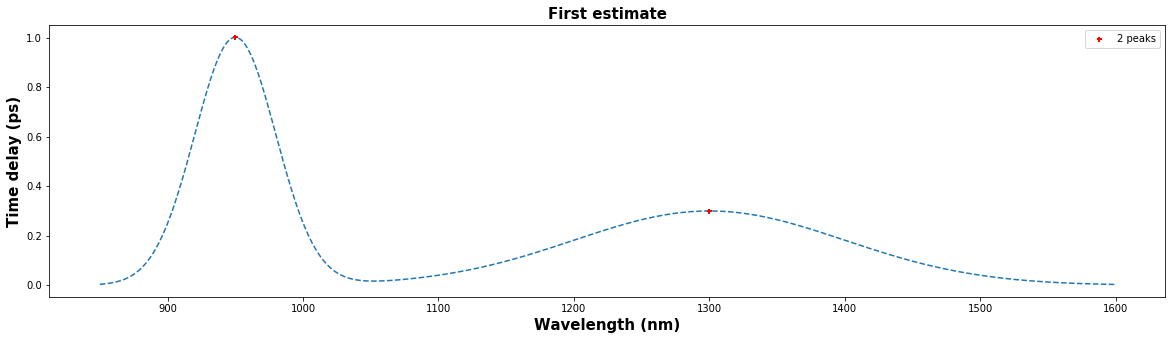

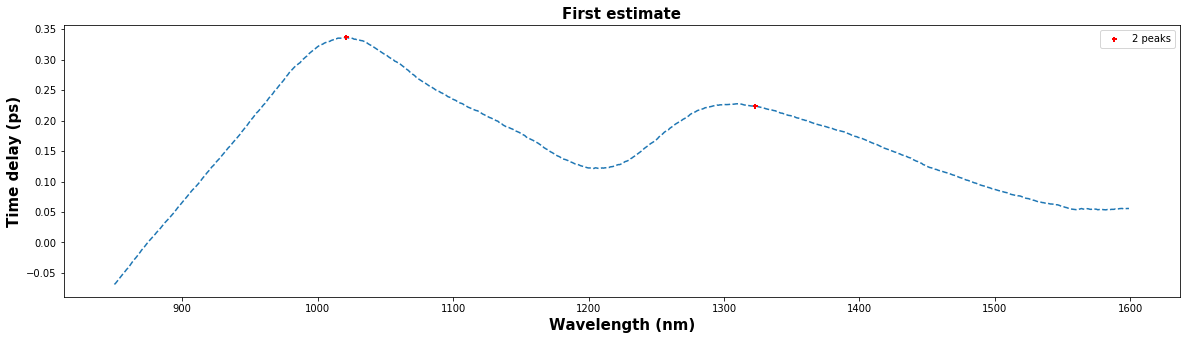

In [254]:
# return denoise curve of a two-gaussian mixture noise model
x = syntheticdata.nm
y = (syntheticdata.species_1 + syntheticdata.species_2)
noise_coefficient =0.1
yhat2=savitzky_golay_smoothing(x, y, noise_coefficient, 577, 3)
peak_finding(x,y)
peak_finding(x,yhat2)

## when window_size is around 55...

[100 450]
[ 950 1300] [1.00065625 0.3       ]
[101 436]
[ 951 1286] [0.97373159 0.29680374]


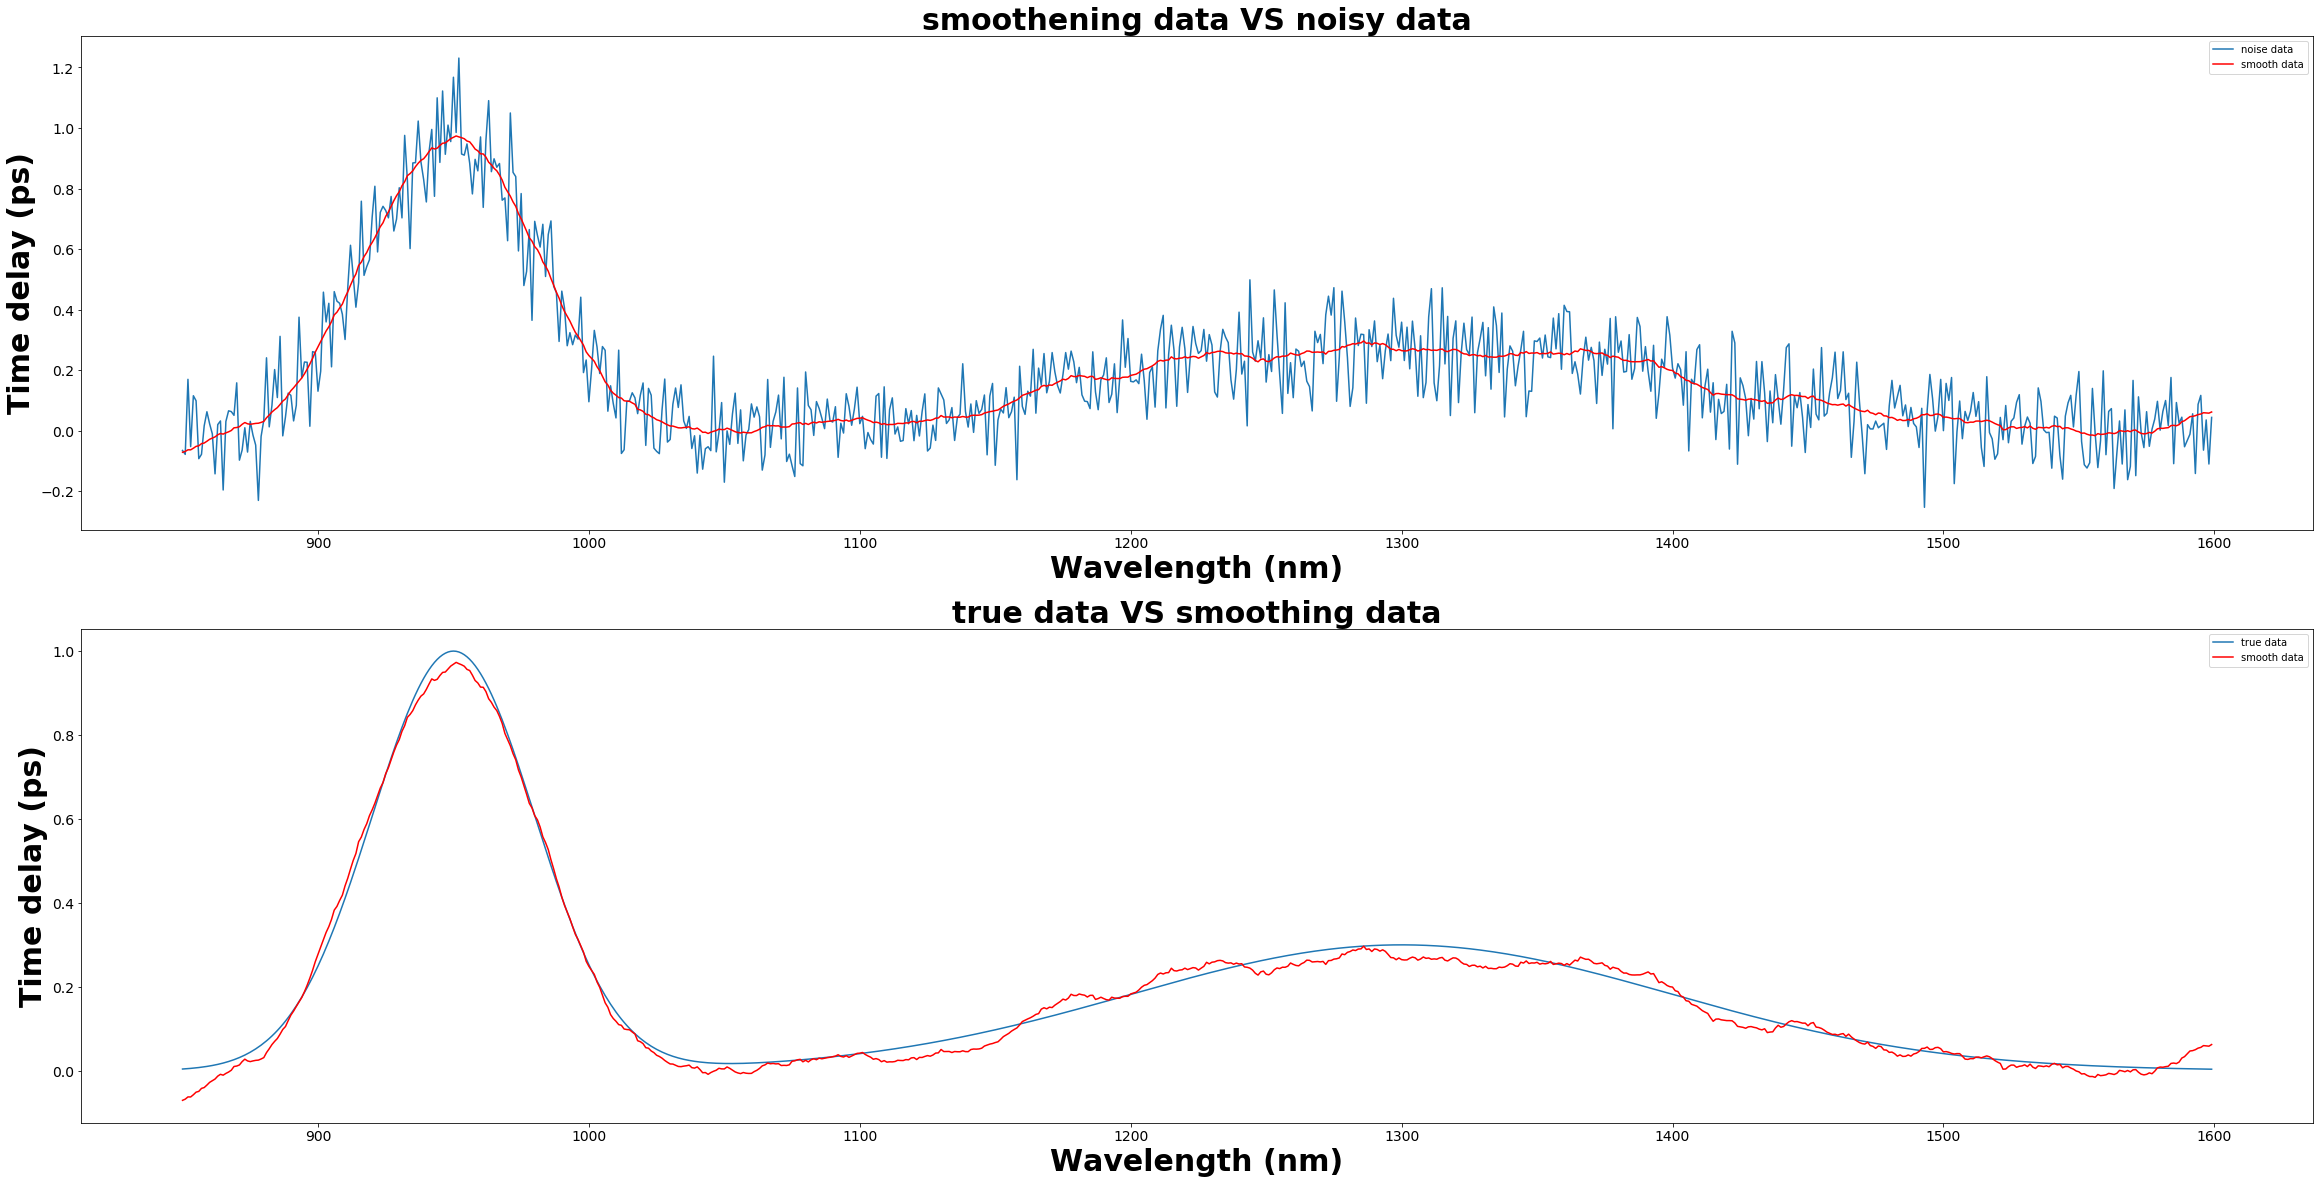

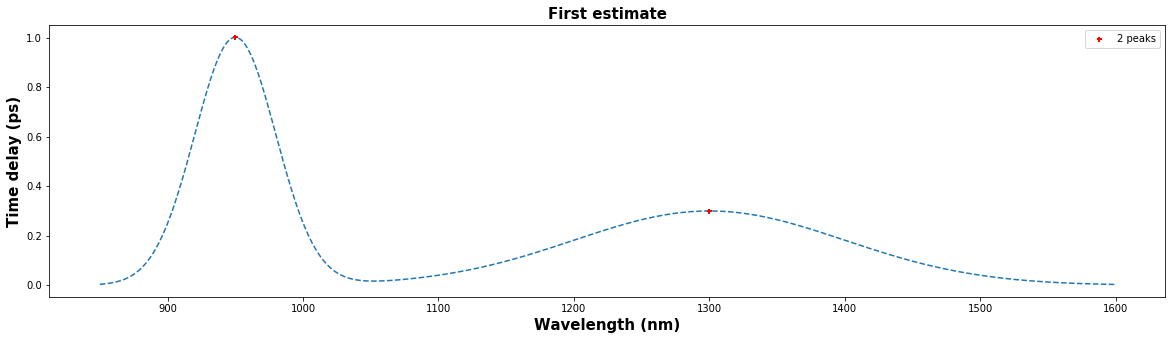

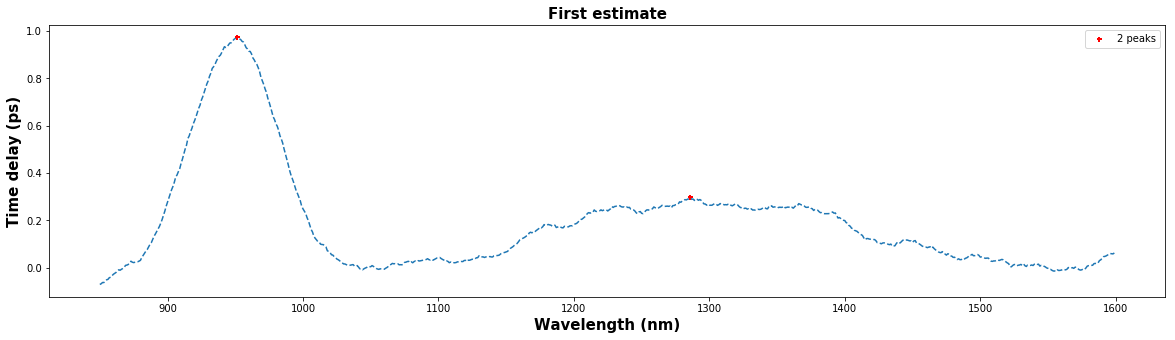

In [314]:
# return denoise curve of a two-gaussian mixture noise model
x = syntheticdata.nm
y = (syntheticdata.species_1 + syntheticdata.species_2)
noise_coefficient =0.1
yhat3=savitzky_golay_smoothing(x, y, noise_coefficient,57,3)
peak_finding(x,y)
peak_finding(x,yhat3)

## lorentzian

[100 448]
[ 950 1298] [0.03355975 0.00324469]
[101 432 746]
[ 951 1282 1596] [0.03054694 0.00243661 0.00595934]


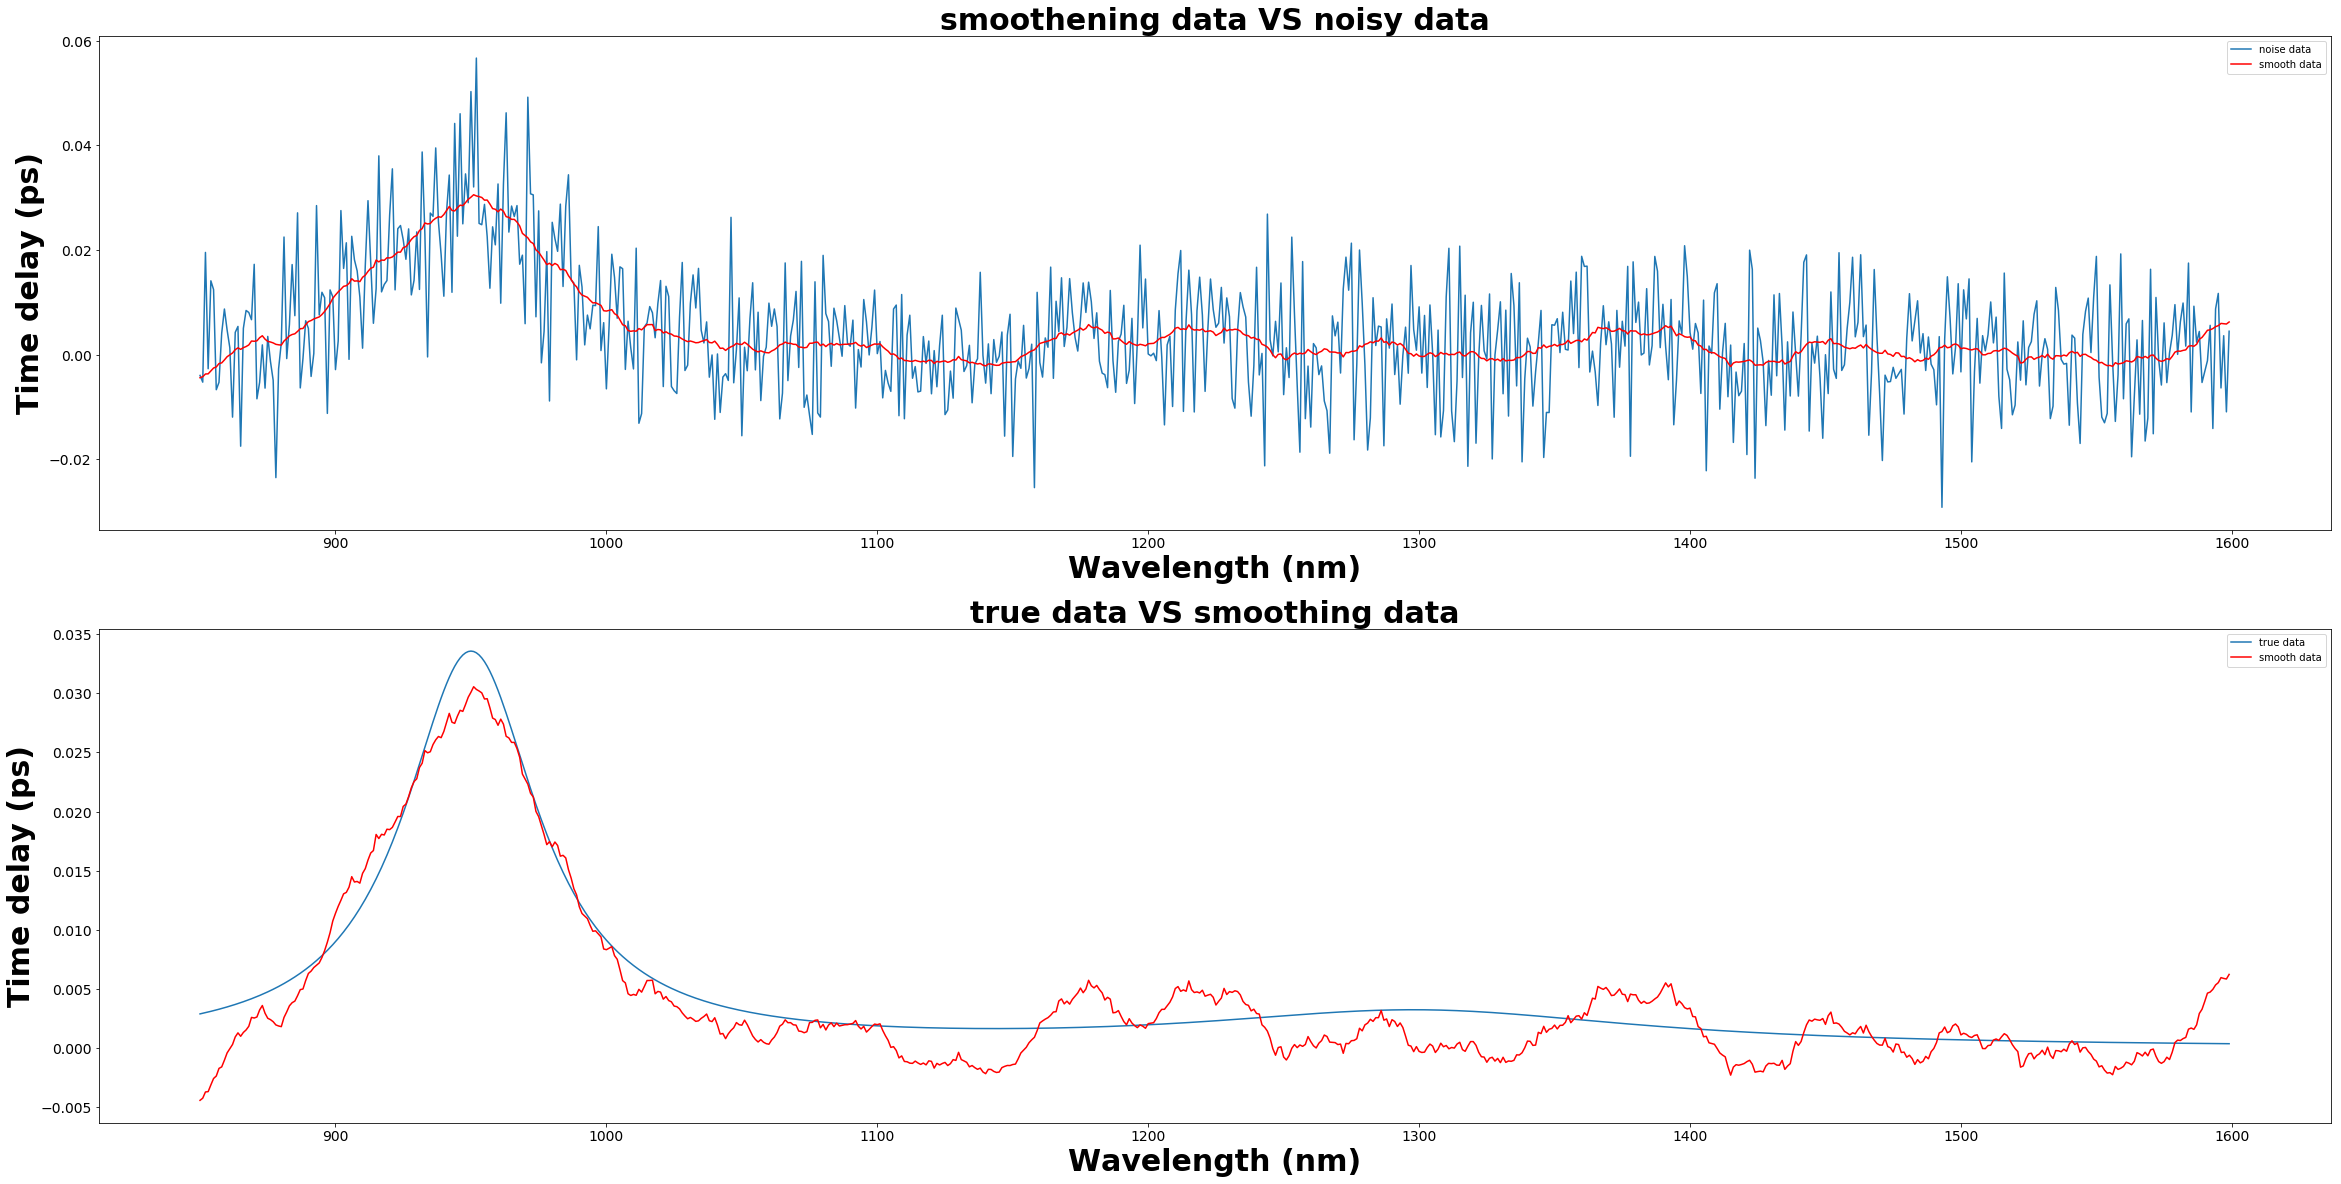

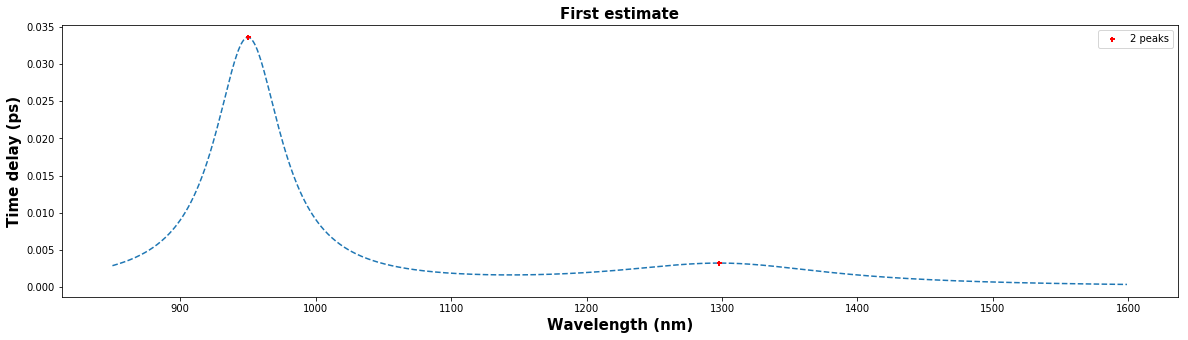

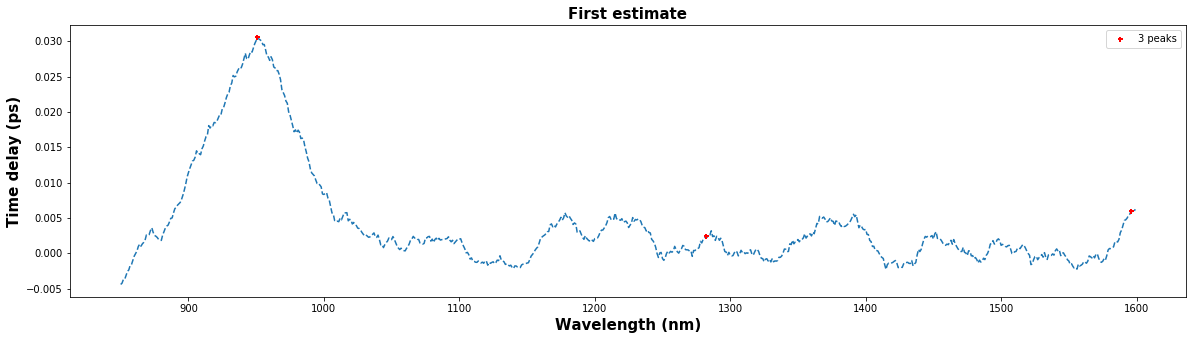

In [315]:
# return denoise curve of a two-gaussian mixture noise model
x = syntheticdata.nm
y = (lorentzian.species_1 + lorentzian.species_2)
noise_coefficient =0.01
yhat3=savitzky_golay_smoothing(x, y, noise_coefficient,57,3)
peak_finding(x,y)
peak_finding(x,yhat3)

# Smoothing 2 -- py-earth

In [319]:
def peak_finding(x,y):
    indexes = peakutils.indexes(y, thres=0, min_dist=30)
    print(indexes)
    print(x[indexes], y[indexes])
    plt.figure(figsize=(30,10))
    pplot(x, y, indexes)
    plt.title('First estimate', fontsize = 15, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 15, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 15, fontweight = 'bold')

In [320]:
def Earth_Smoothing(nm_array, timedelay, noise_coefficient):
    import numpy
    import matplotlib.pyplot as plt
    from pyearth import Earth
    
    """
     ============================================
     Plotting derivatives of simple sine function
    ============================================

     A simple example plotting a fit of the sine function
    and the derivatives computed by Earth.
    
    Notes
    -----   
    generates a denoise curve from the TA data
    Parameters
    ----------
        nm_array: wavelength array
        timedelay: time delay array
        noise_coefficient: the noise coefficients that user want to generate
    Returns
    -------
        a smoothing curve from the original noise curve   
    """
    # Create some fake data
    # generate some noisy data from syntheticdata:
    np.random.seed(1729)
    y_noise = noise_coefficient * np.random.normal(size=nm_array.size)
    ydata = timedelay + y_noise
    
   # Fit an Earth model
    model = Earth(max_degree=2, minspan_alpha=.5, smooth=True)
    model.fit(nm_array, ydata)
    
    # Print the model
    print(model.trace())
    print(model.summary())
    
   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)
   
    # Plot true and predicted function values 
    plt.figure(figsize=(50,40))
    plt.subplot(311)
    plt.title('Peak Smoothening', fontsize = 30, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.plot(nm_array, ydata, 'r.')
    plt.plot(nm_array, y_hat, 'b.')
    plt.ylabel('function')
    
    plt.subplot(312)
    plt.title('True data', fontsize = 30, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.plot(nm_array,timedelay,color='red', markersize = 200,label = 'true peak')
    plt.plot(nm_array,y_hat, color='blue', markersize = 200,label = 'smooth peak')
    plt.legend()
    
    plt.subplot(313)
    plt.title('data differ', fontsize = 30, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0, color='blue', linestyle='-')
    plt.plot(nm_array,y_hat-timedelay, color='red')
    plt.legend()
    
    return y_hat

## two-gaussian

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

No handles with labels found to put in legend.


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.061328  1      0.061  0.000  0.000  
1     0       0    67    0.045732  3      0.046  0.254  0.244  
2     1       0    142   0.020814  5      0.021  0.661  0.651  
3     1       0    382   0.011135  7      0.012  0.818  0.811  
4     1       0    162   0.010550  9      0.011  0.828  0.818  
5     0       0    27    0.010152  11     0.011  0.834  0.823  
6     0       0    127   0.009886  13     0.011  0.839  0.825  
7     0       0    462   0.009645  15     0.011  0.843  0.827  
8     13      0    574   0.009432  17     0.011  0.846  0.828  
9     0       0    -1    0.009400  18     0.011  0.847  0.828  
---------------------------------------------------------------
Stopping Condition 2: Improvement below threshold

Pruning Pass
---------------------------

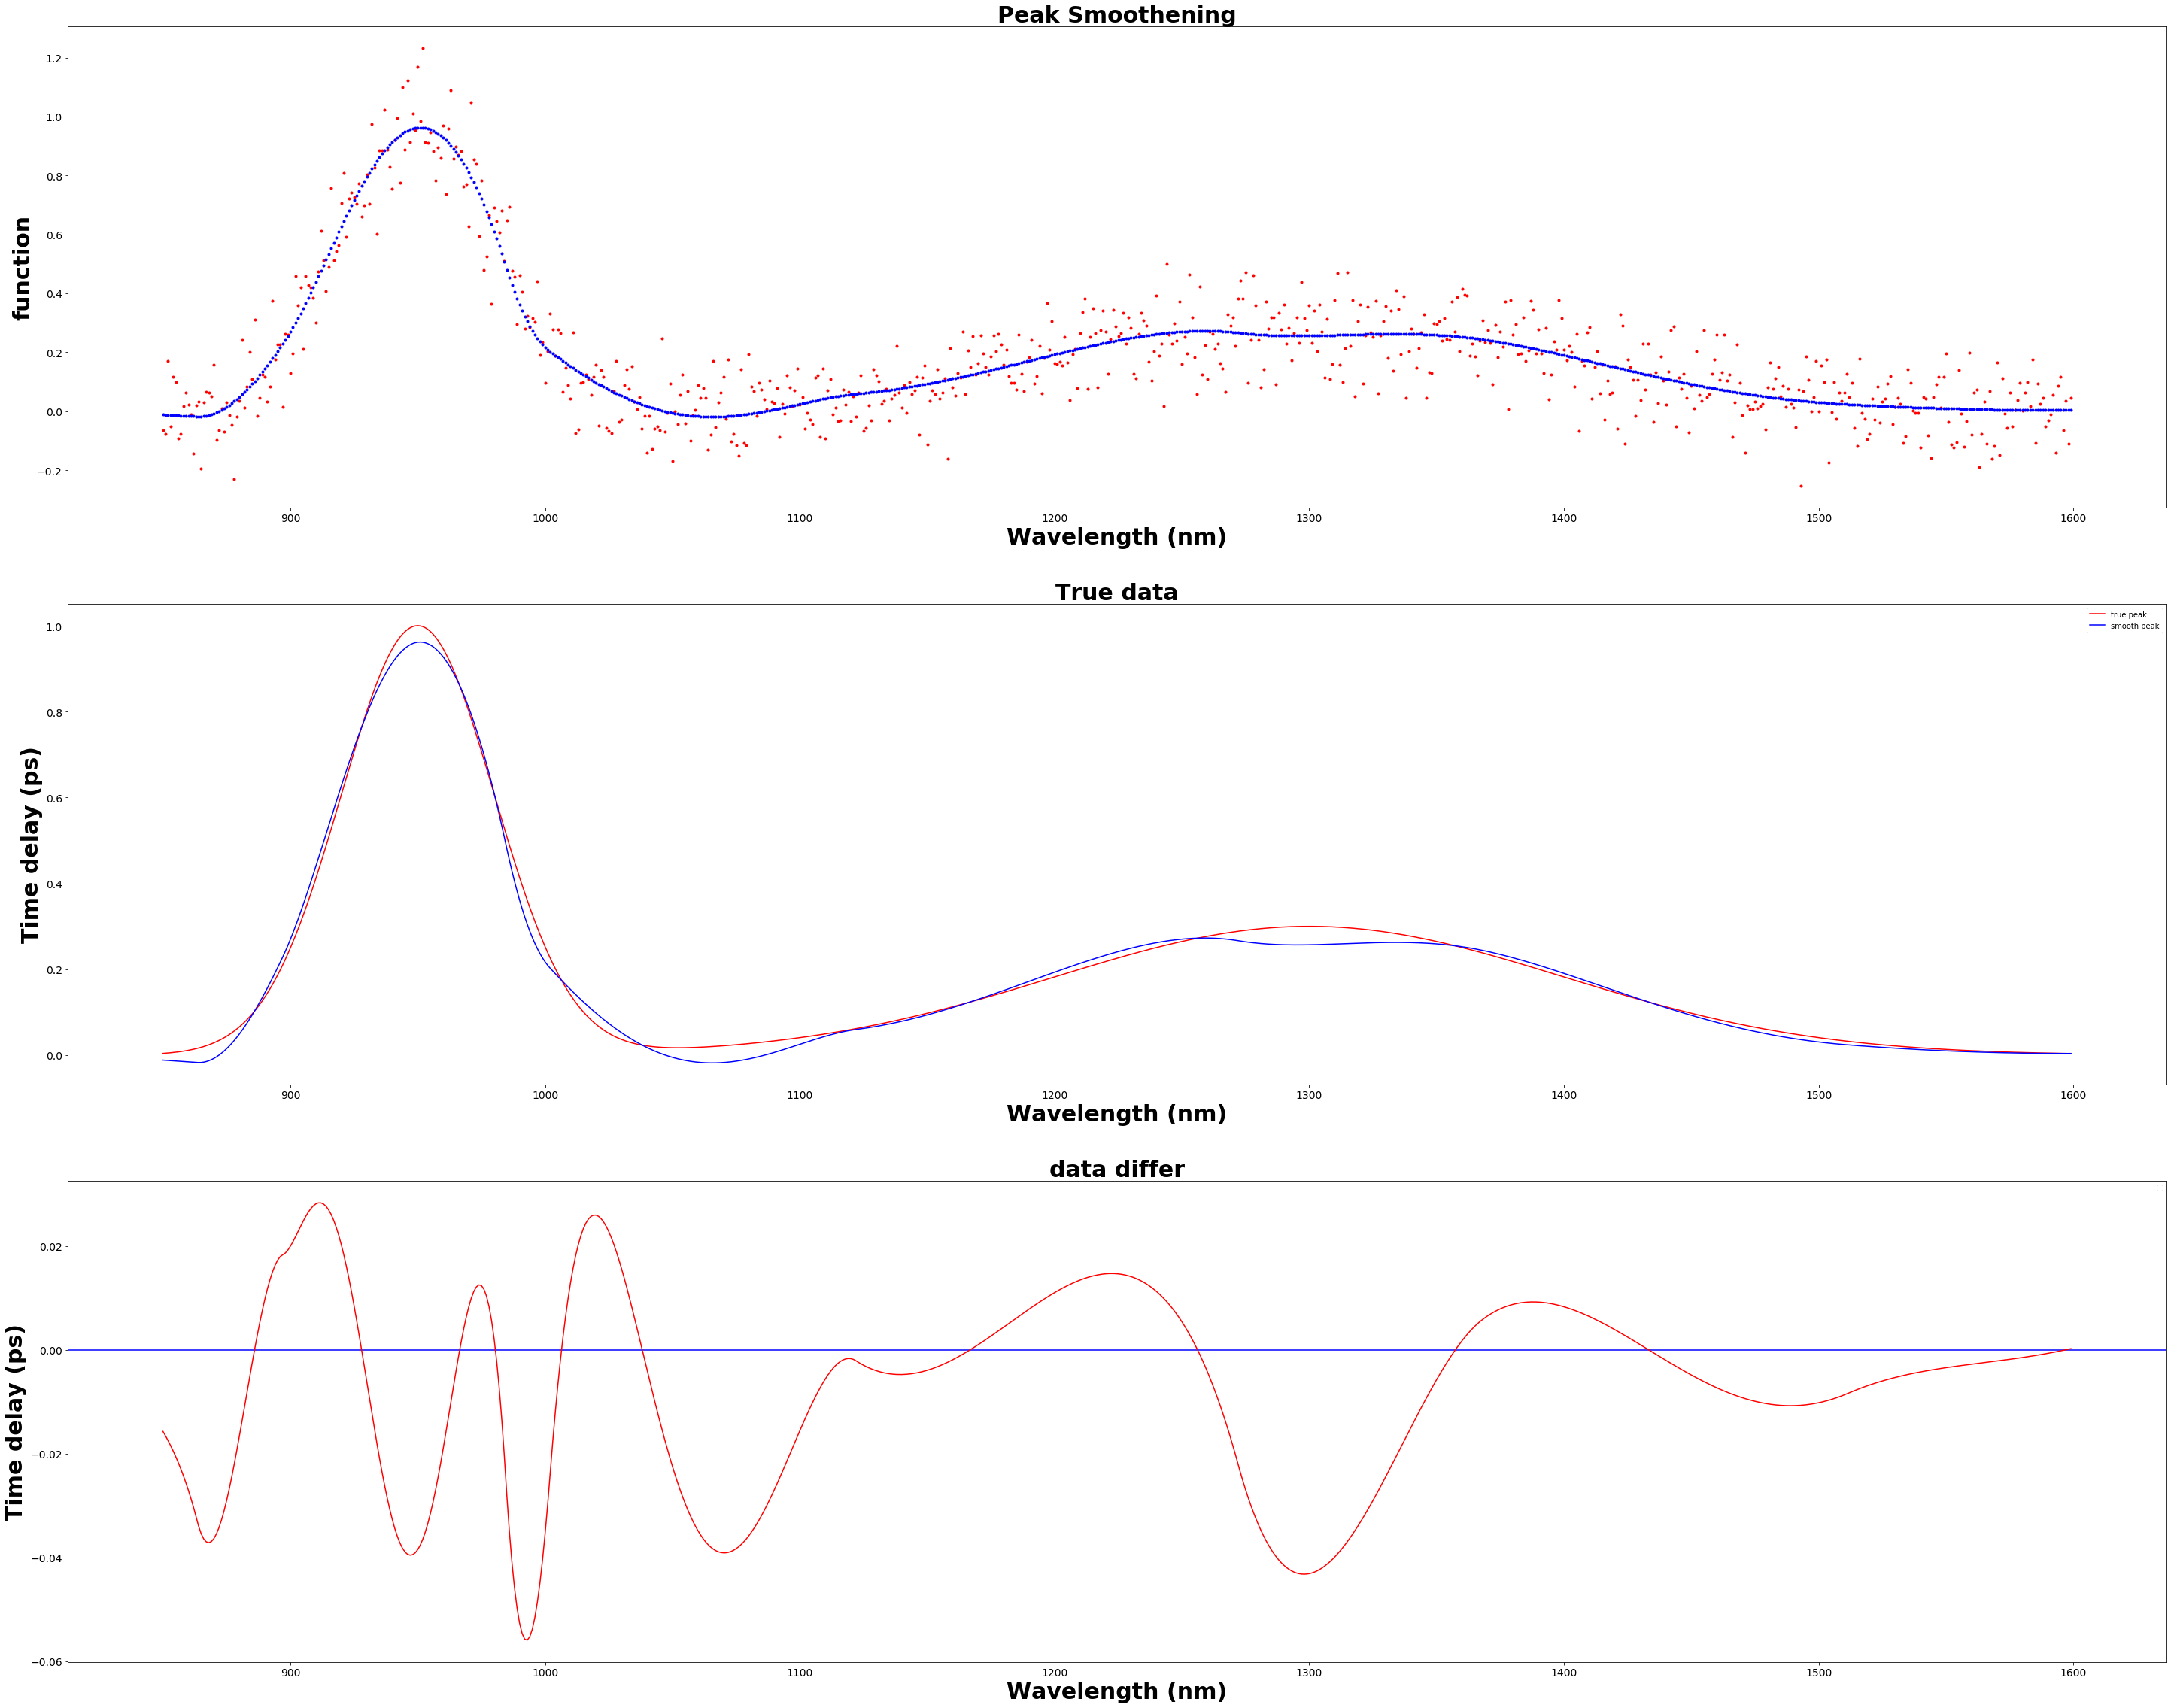

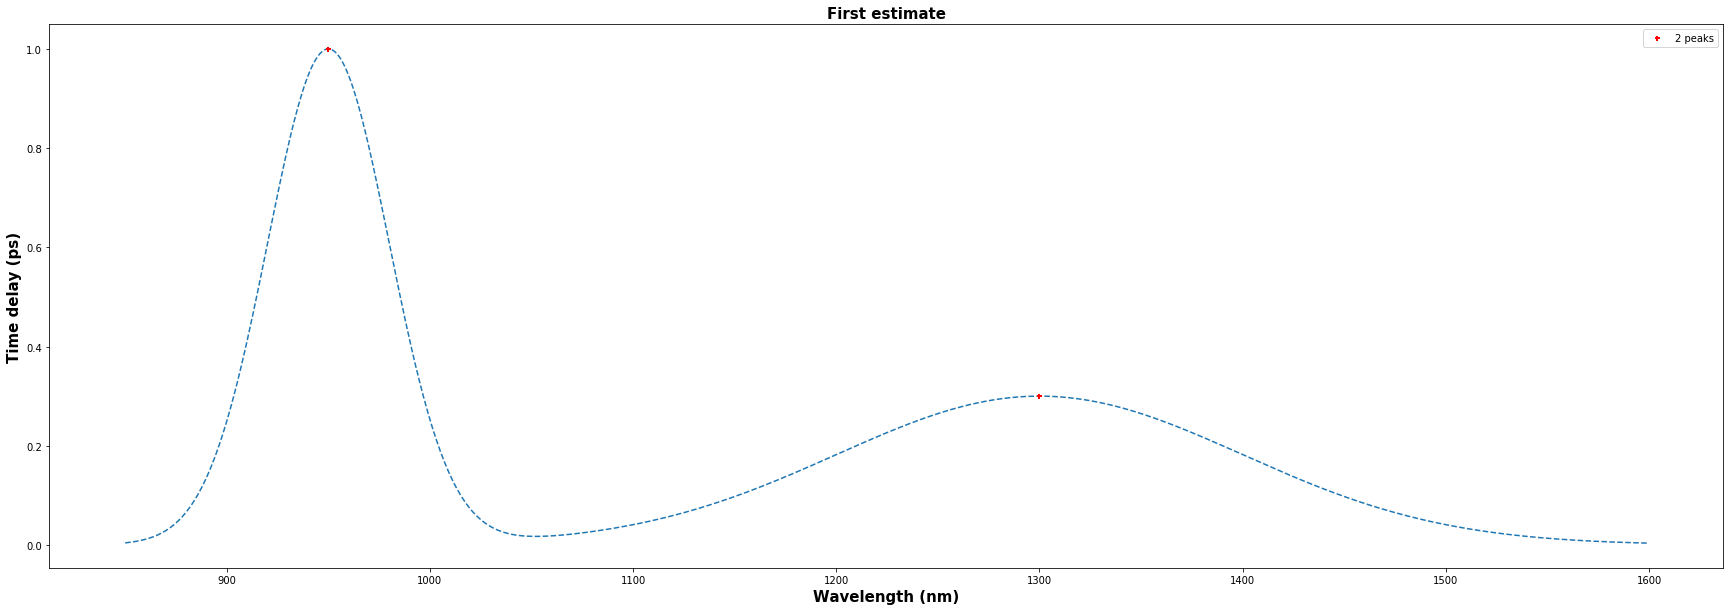

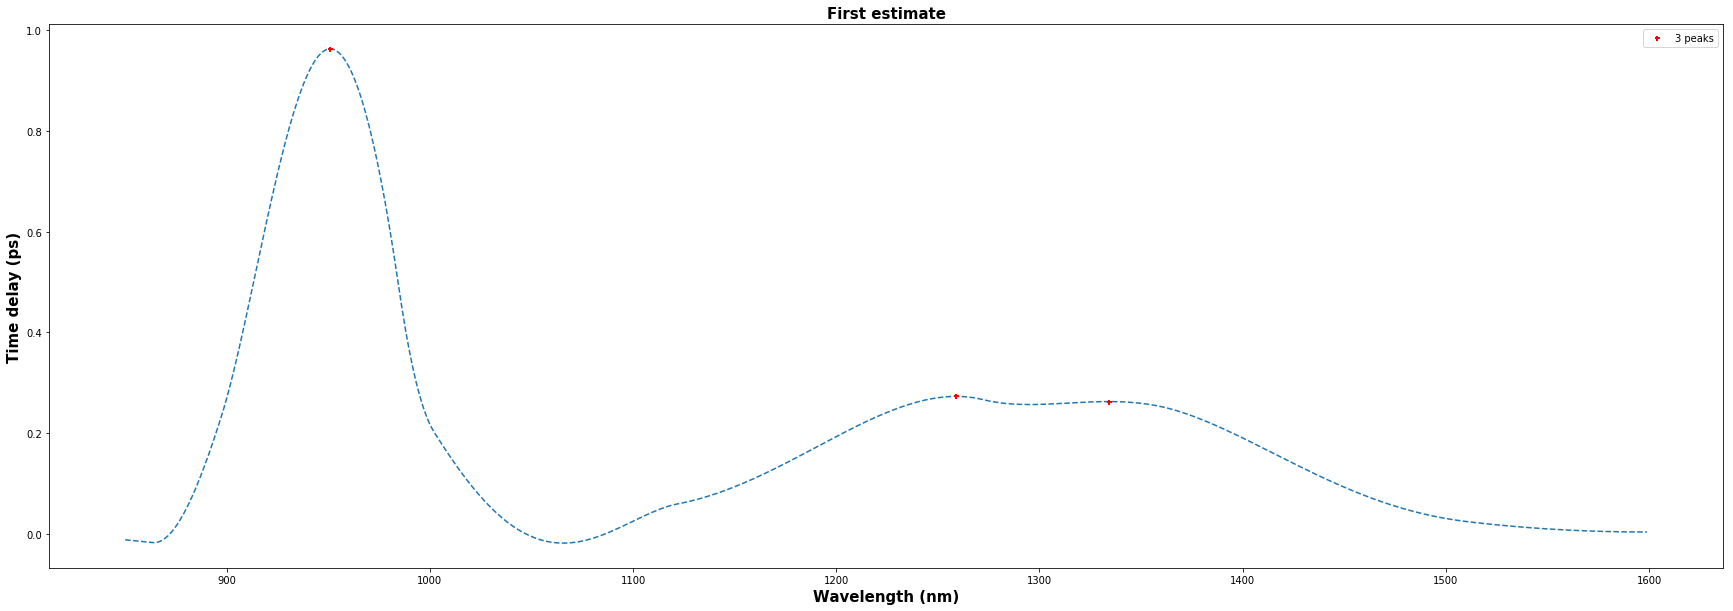

In [321]:
# return denoise curve of a two-gaussian mixture noise model
nm_array = syntheticdata.nm
timedelay = (syntheticdata.species_1 + syntheticdata.species_2)
noise_coefficient =0.1
ysmooth = Earth_Smoothing(nm_array, timedelay, noise_coefficient)
peak_finding(nm_array,timedelay)
peak_finding(nm_array,ysmooth)

## three-gaussian

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

No handles with labels found to put in legend.


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.065045  1      0.065  0.000  0.000  
1     0       0    82    0.021554  3      0.022  0.669  0.664  
2     1       0    130   0.015264  5      0.016  0.765  0.759  
3     1       0    242   0.012054  7      0.013  0.815  0.807  
4     2       0    49    0.011013  9      0.012  0.831  0.821  
5     1       0    150   0.010195  11     0.011  0.843  0.832  
6     0       0    357   0.009788  13     0.011  0.850  0.837  
7     11      0    622   0.009515  15     0.010  0.854  0.839  
8     0       0    512   0.009439  17     0.011  0.855  0.838  
9     11      0    -1    0.009431  18     0.011  0.855  0.837  
---------------------------------------------------------------
Stopping Condition 2: Improvement below threshold

Pruning Pass
---------------------------

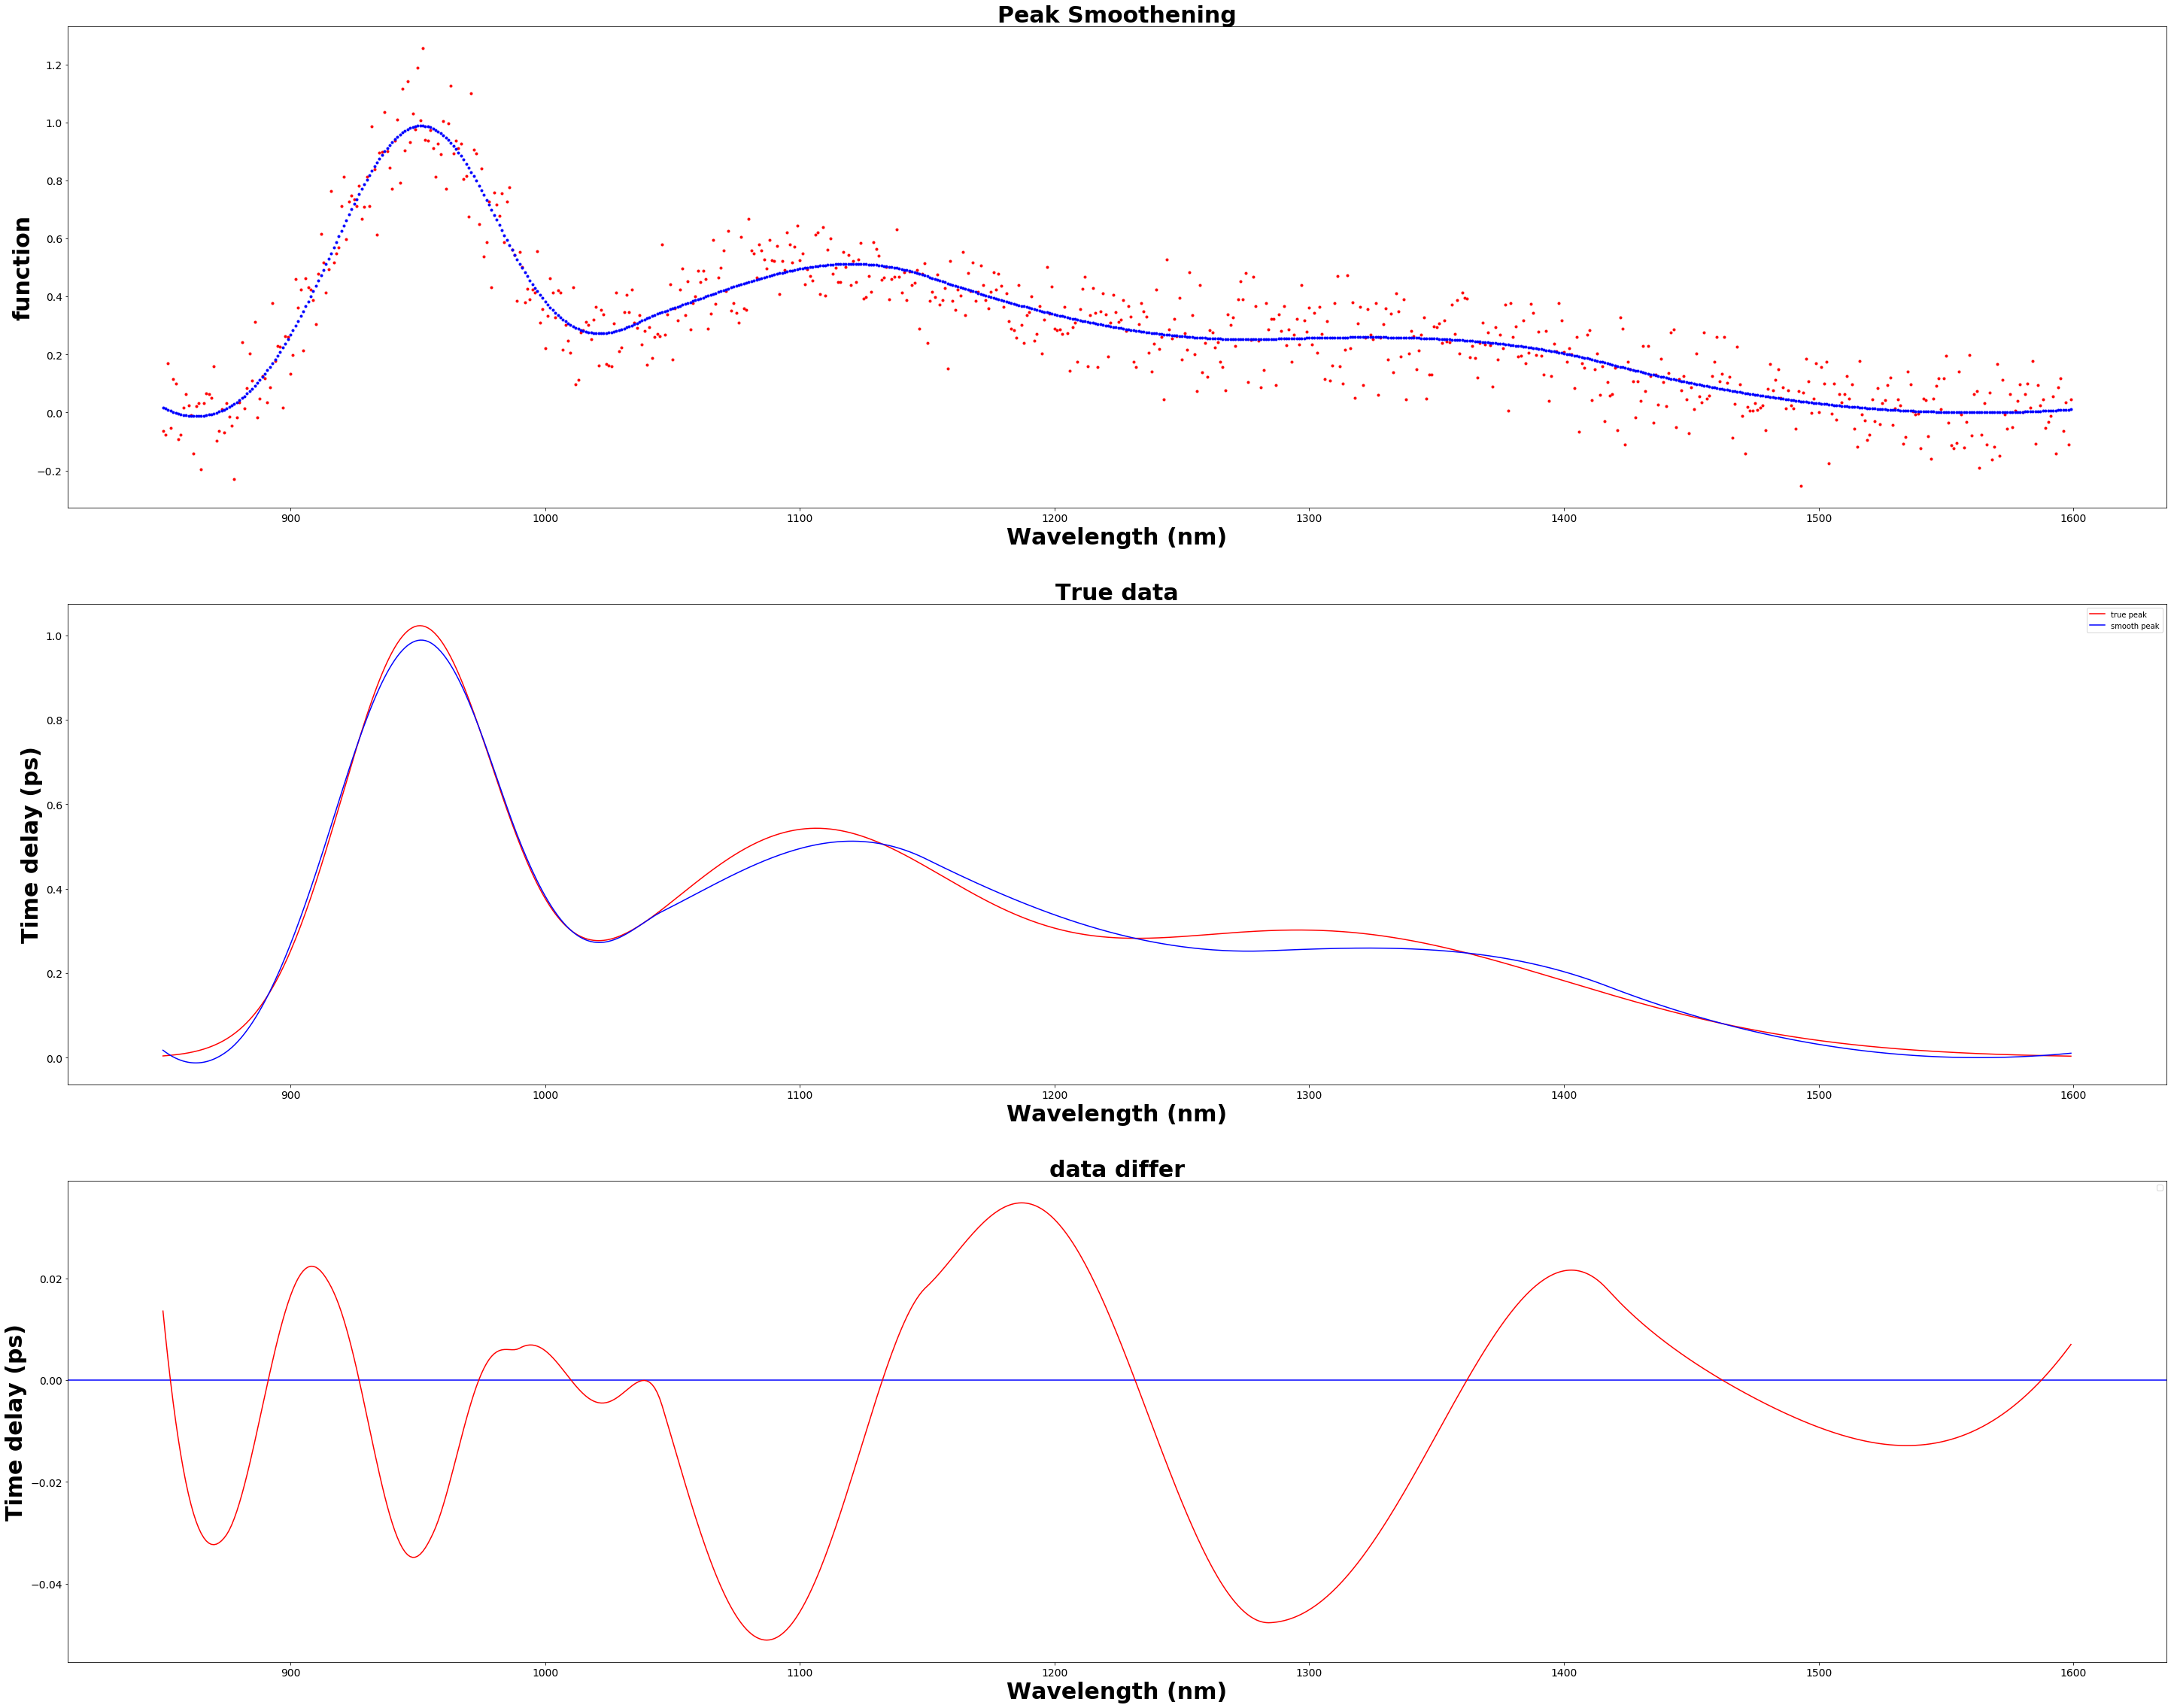

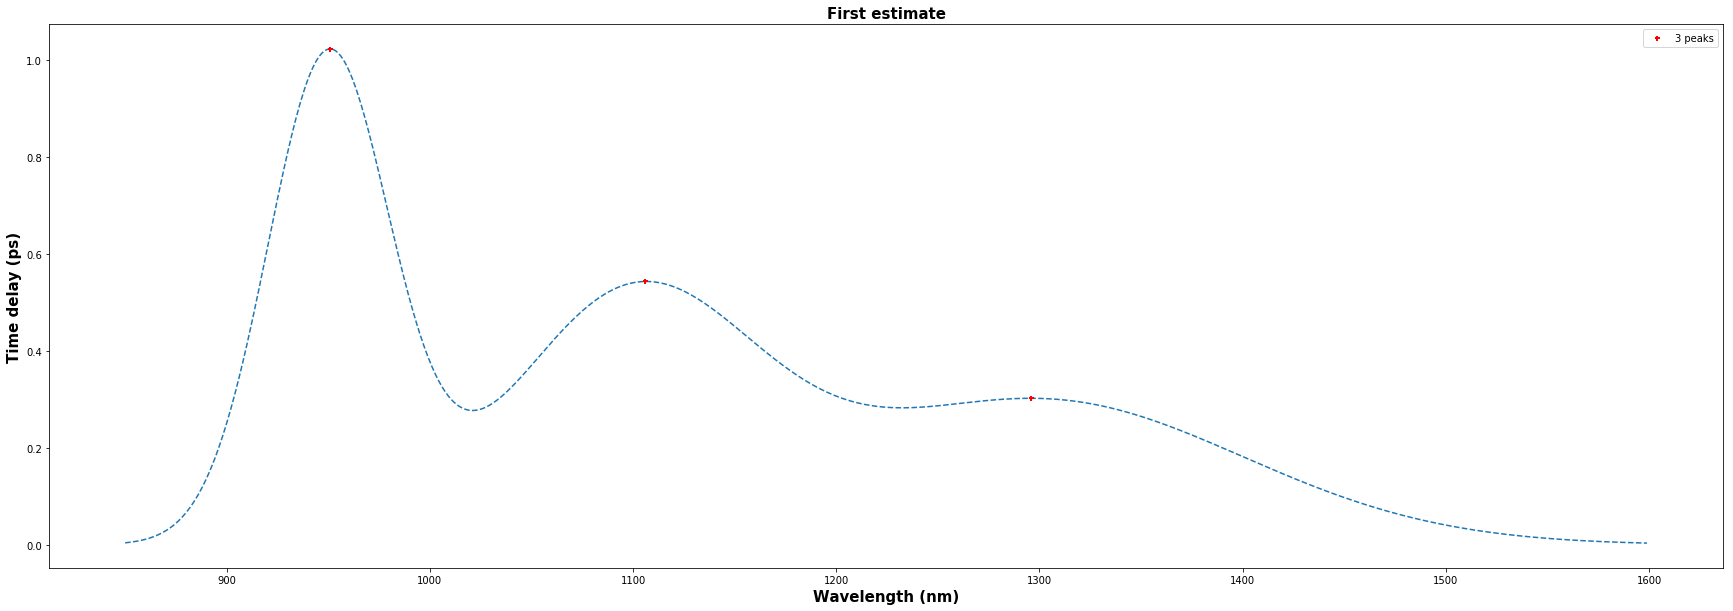

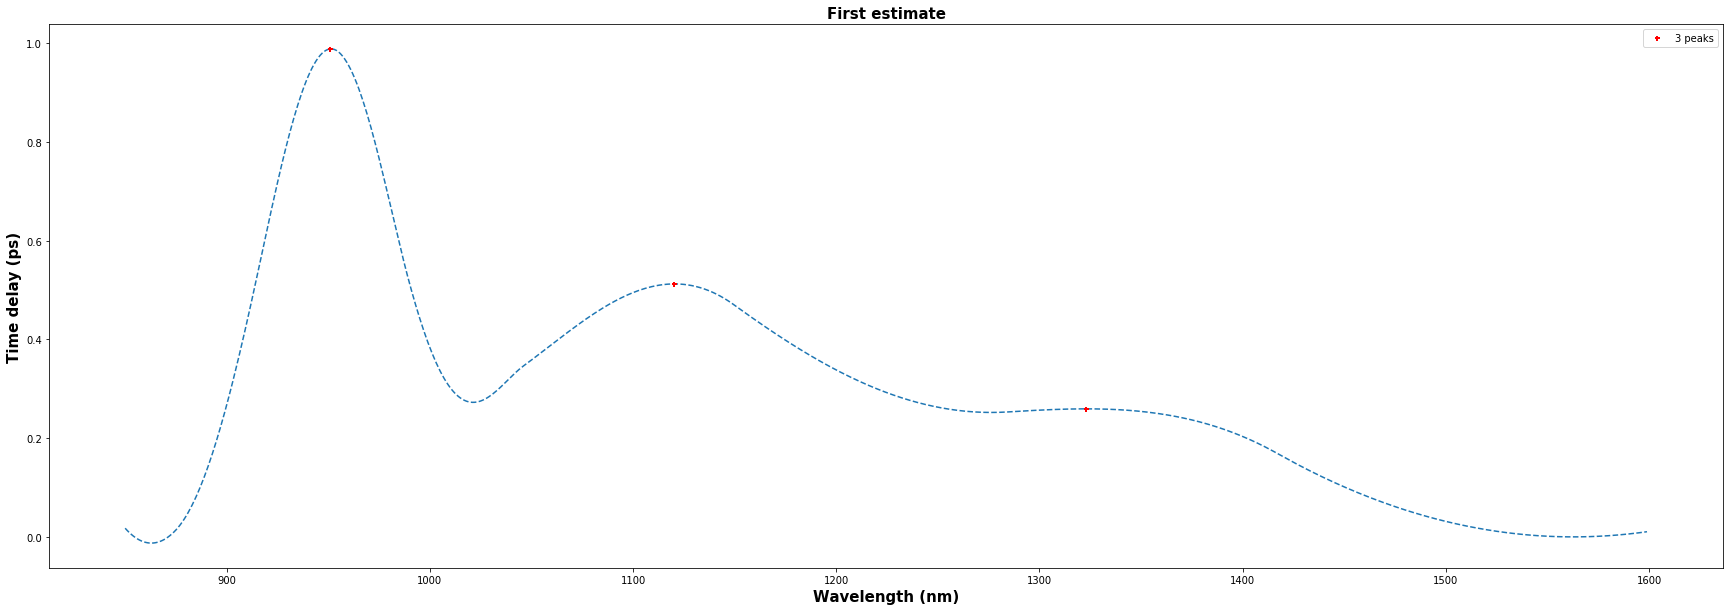

In [322]:
# return denoise curve of a three-gaussian mixture noise model
nm_array = syntheticdata.nm
timedelay = threegaussians.species_1 + threegaussians.species_2+threegaussians.species_3
noise_coefficient =0.1
ysmooth=Earth_Smoothing(nm_array, timedelay, noise_coefficient)
peak_finding(nm_array,timedelay)
peak_finding(nm_array,ysmooth)

##  lorentzian noise model

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

No handles with labels found to put in legend.


Forward Pass
----------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq    
----------------------------------------------------------------
0     -       -    -     0.009670  1      0.010  0.000  0.000   
1     0       0    -1    0.009664  2      0.010  0.001  -0.006  
----------------------------------------------------------------
Stopping Condition 2: Improvement below threshold

Pruning Pass
---------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq    
---------------------------------------------
0     -   2      0.01  0.010  0.001  -0.006  
1     1   1      0.01  0.010  0.000  0.000   
---------------------------------------------
Selected iteration: 1

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      -0.003554    
x0              Yes     None         
--------------------------------

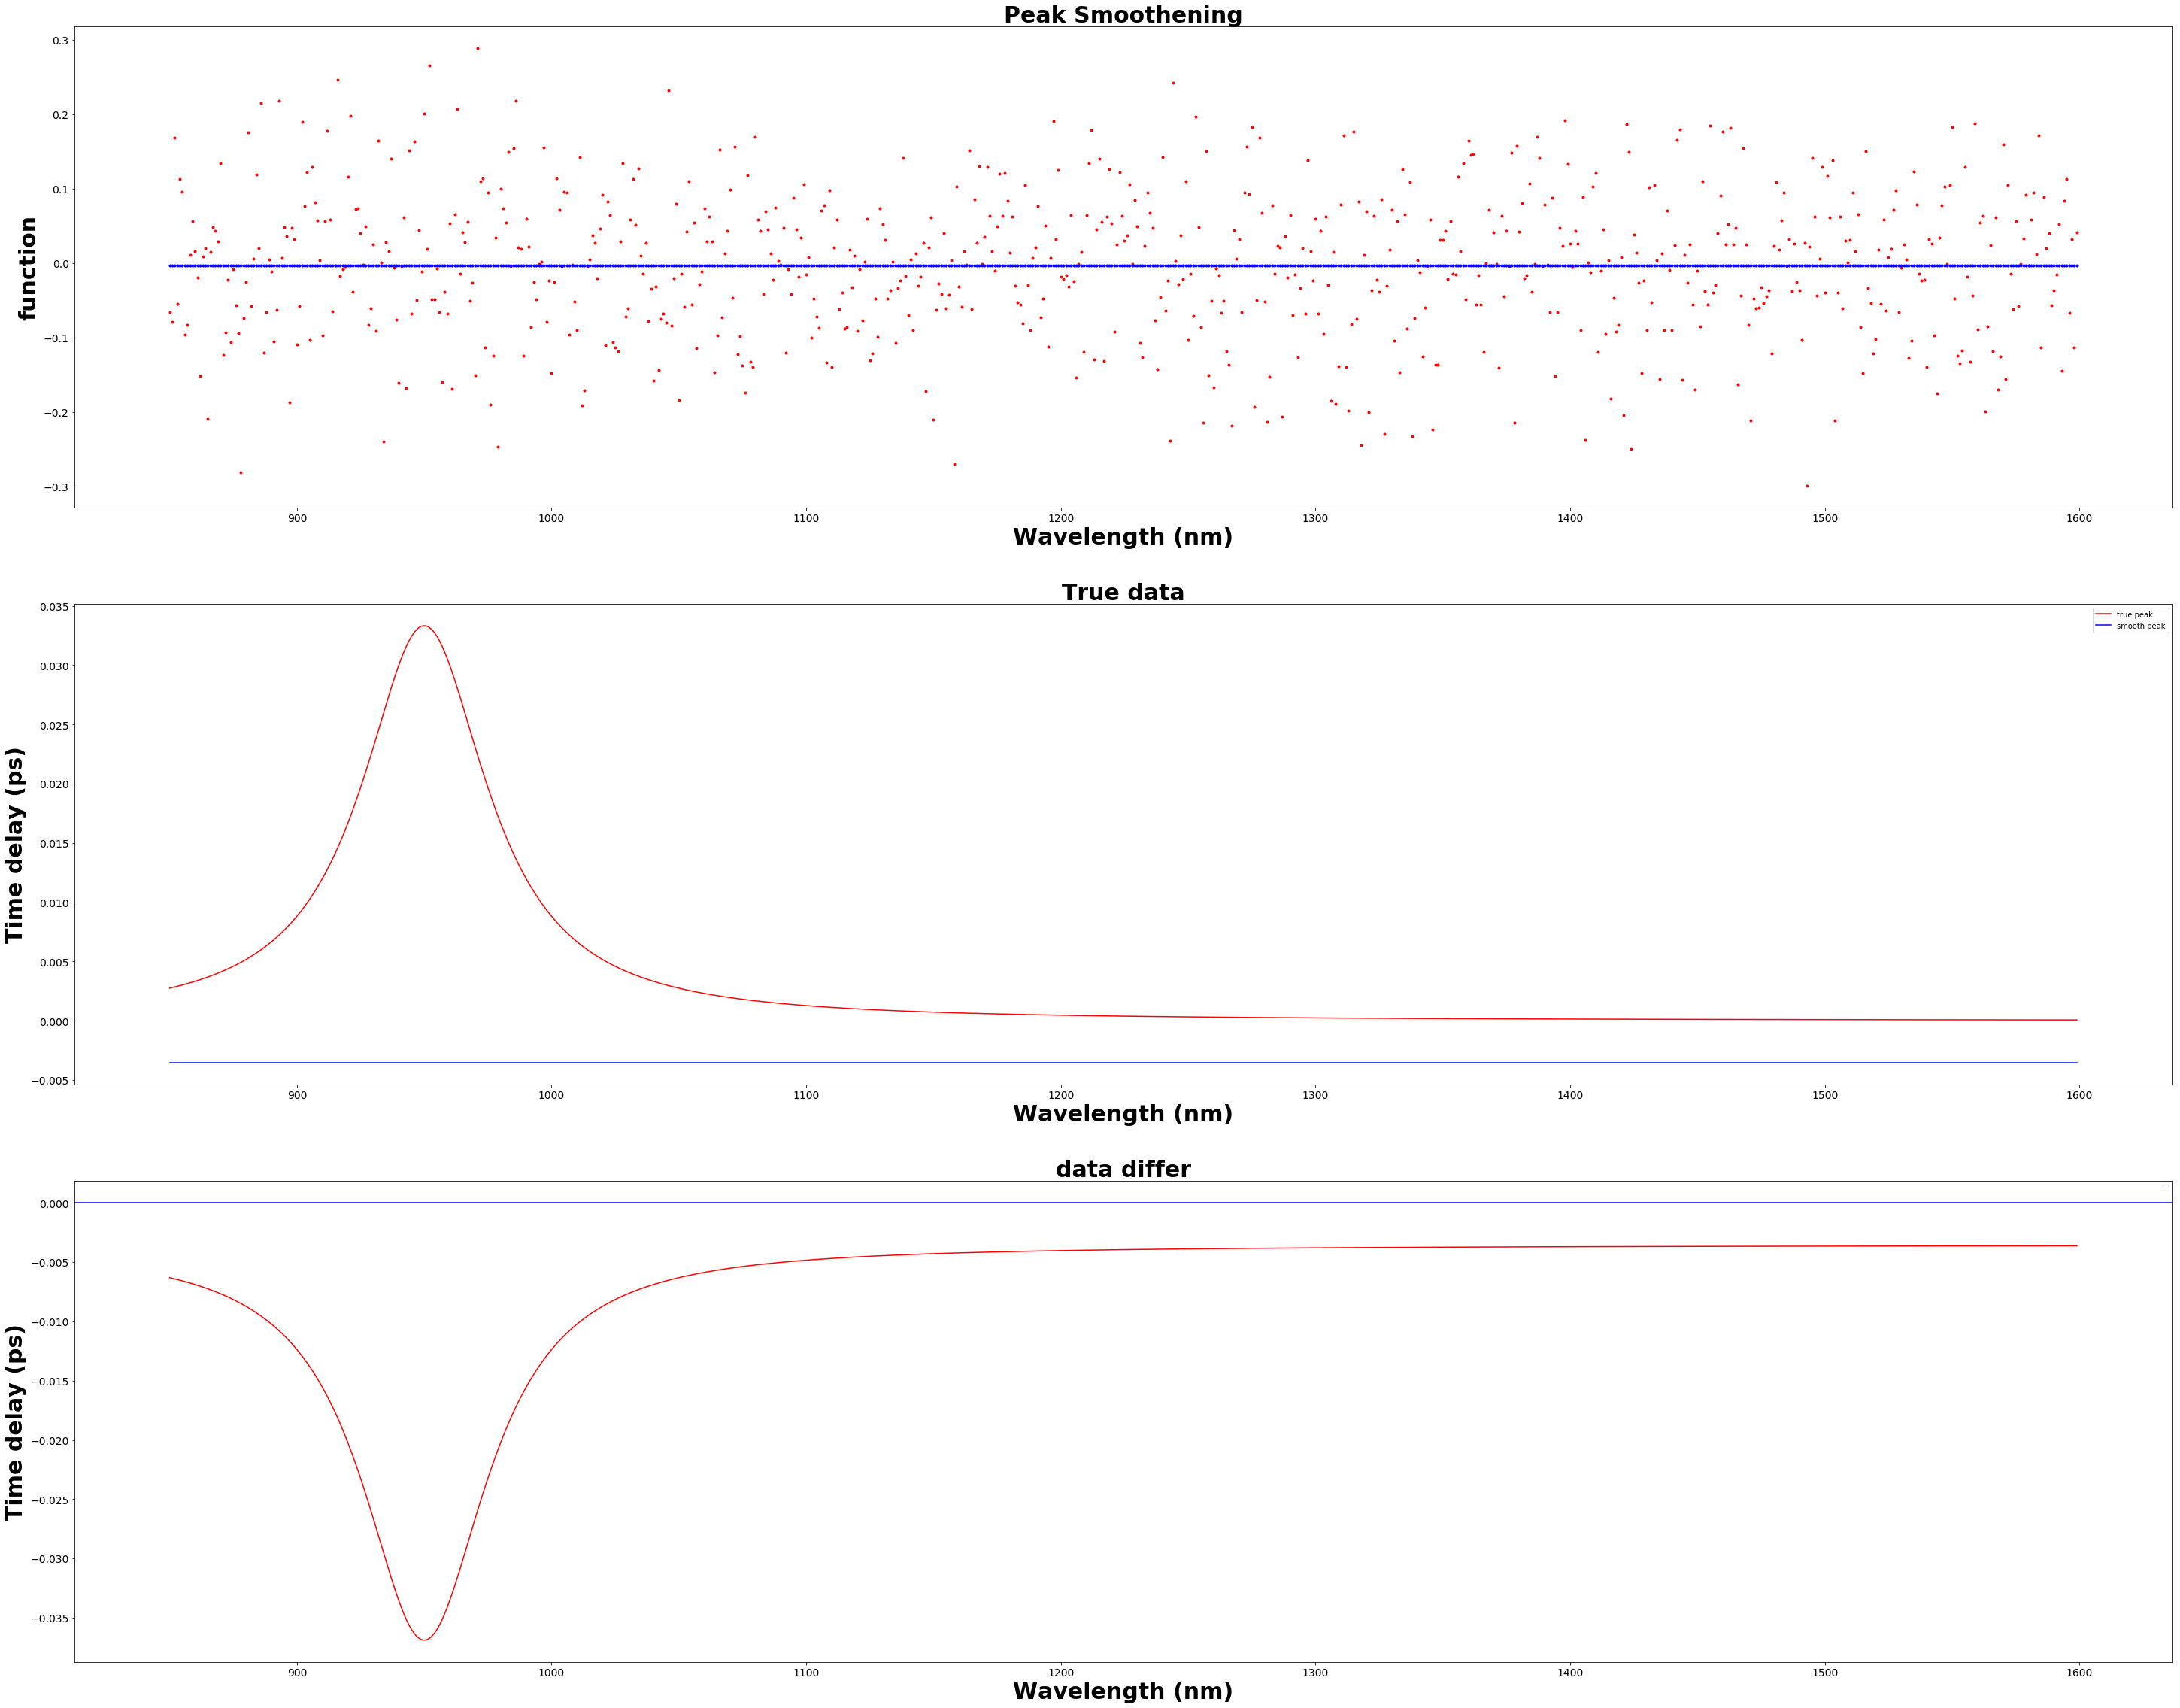

In [323]:
# return denoise curve of a lorentzian noise model
nm_array = syntheticdata.nm
timedelay = lorentzian.species_1
noise_coefficient =0.1
ysmooth=Earth_Smoothing(nm_array, timedelay, noise_coefficient)

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

No handles with labels found to put in legend.


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.000056  1      0.000  0.000  0.000  
1     0       0    312   0.000030  3      0.000  0.464  0.457  
2     2       0    104   0.000005  5      0.000  0.906  0.903  
3     0       0    97    0.000003  7      0.000  0.950  0.948  
4     2       0    164   0.000001  9      0.000  0.974  0.973  
5     5       0    126   0.000001  11     0.000  0.983  0.981  
6     1       0    334   0.000001  13     0.000  0.983  0.982  
---------------------------------------------------------------
Stopping Condition 2: Improvement below threshold

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   13     0.00  0.000  0.983  0.981  
1     6   12     0.00  0.000  0.983  0.

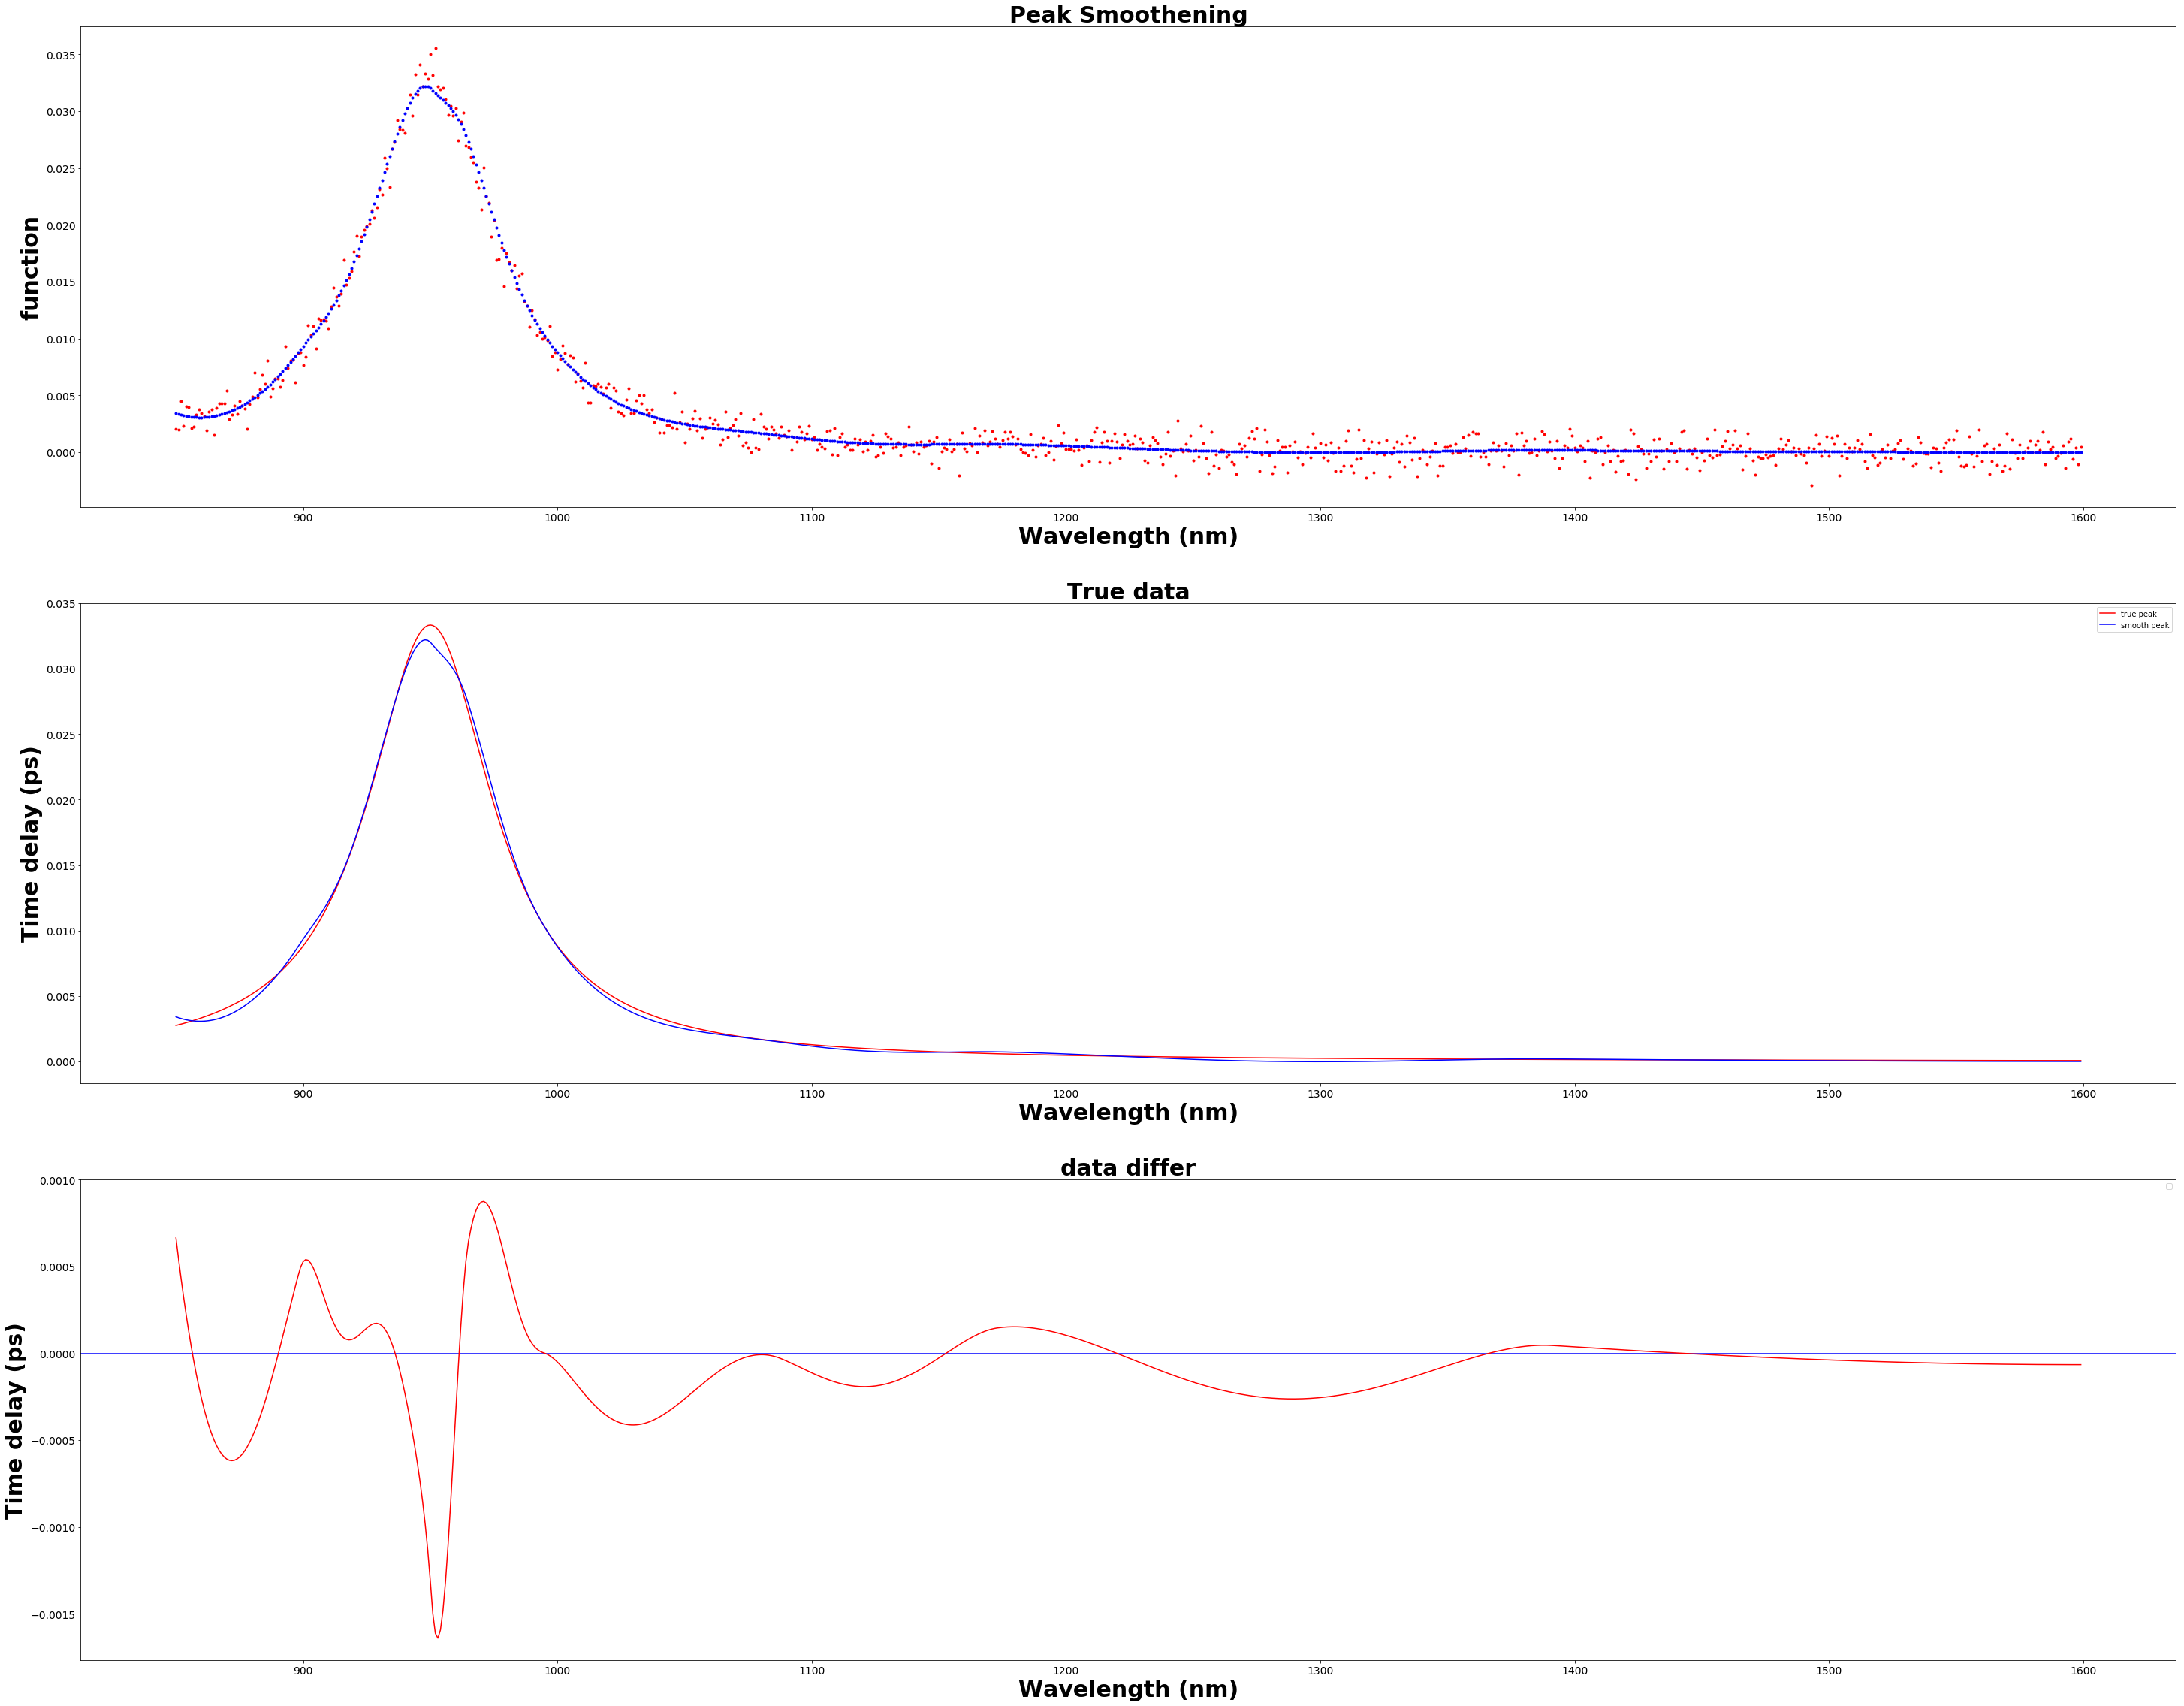

In [324]:
# return denoise curve of a lorentzian noise model
nm_array = syntheticdata.nm
timedelay = lorentzian.species_1
noise_coefficient =0.001
ysmooth=Earth_Smoothing(nm_array, timedelay, noise_coefficient)

# Function 3 -- astropy

In [273]:
def astropy_smoothing(nm_array, timedelay, noise_coefficient,gg_init):
    # Generate fake data
    np.random.seed(42)
    ydata = timedelay + noise_coefficient*np.random.normal(size=nm_array.size)
    # Now to fit the data create a new superposition with initial
    # guesses for the parameters:
    fitter = fitting.SLSQPLSQFitter()
    gg_fit = fitter(gg_init, nm_array, ydata)

    # Plot the data with the best-fit model
    plt.figure(figsize=(50,40))
    plt.subplot(311)
    plt.title('Smoothening data', fontsize = 30, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.plot(nm_array, ydata, 'ko')
    plt.plot(nm_array, gg_fit(nm_array), color='blue')


    plt.subplot(312)
    plt.title('True data', fontsize = 30, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.plot(nm_array,timedelay,color='red')
    plt.plot(nm_array,gg_fit(nm_array), color='blue')
    
    plt.subplot(313)
    plt.title('data differ',fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 15, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0, color='red', linestyle='-')
    plt.plot(nm_array,timedelay-gg_fit(nm_array), color='blue')
    
    return gg_fit(nm_array)

In [277]:
def peak_finding(x,y):
    indexes = peakutils.indexes(y, thres=0, min_dist=50)
    print(indexes)
    print(x[indexes], y[indexes])
    plt.figure(figsize=(20,5))
    pplot(x, y, indexes)
    plt.title('First estimate', fontsize = 15, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 15, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 15, fontweight = 'bold')

## two gaussian

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.226274822170879
            Iterations: 17
            Function evaluations: 141
            Gradient evaluations: 17
[100 450]
[ 950 1300] [1.00065625 0.3       ]
[100 445]
[ 950 1295] [0.9998227 0.2929588]


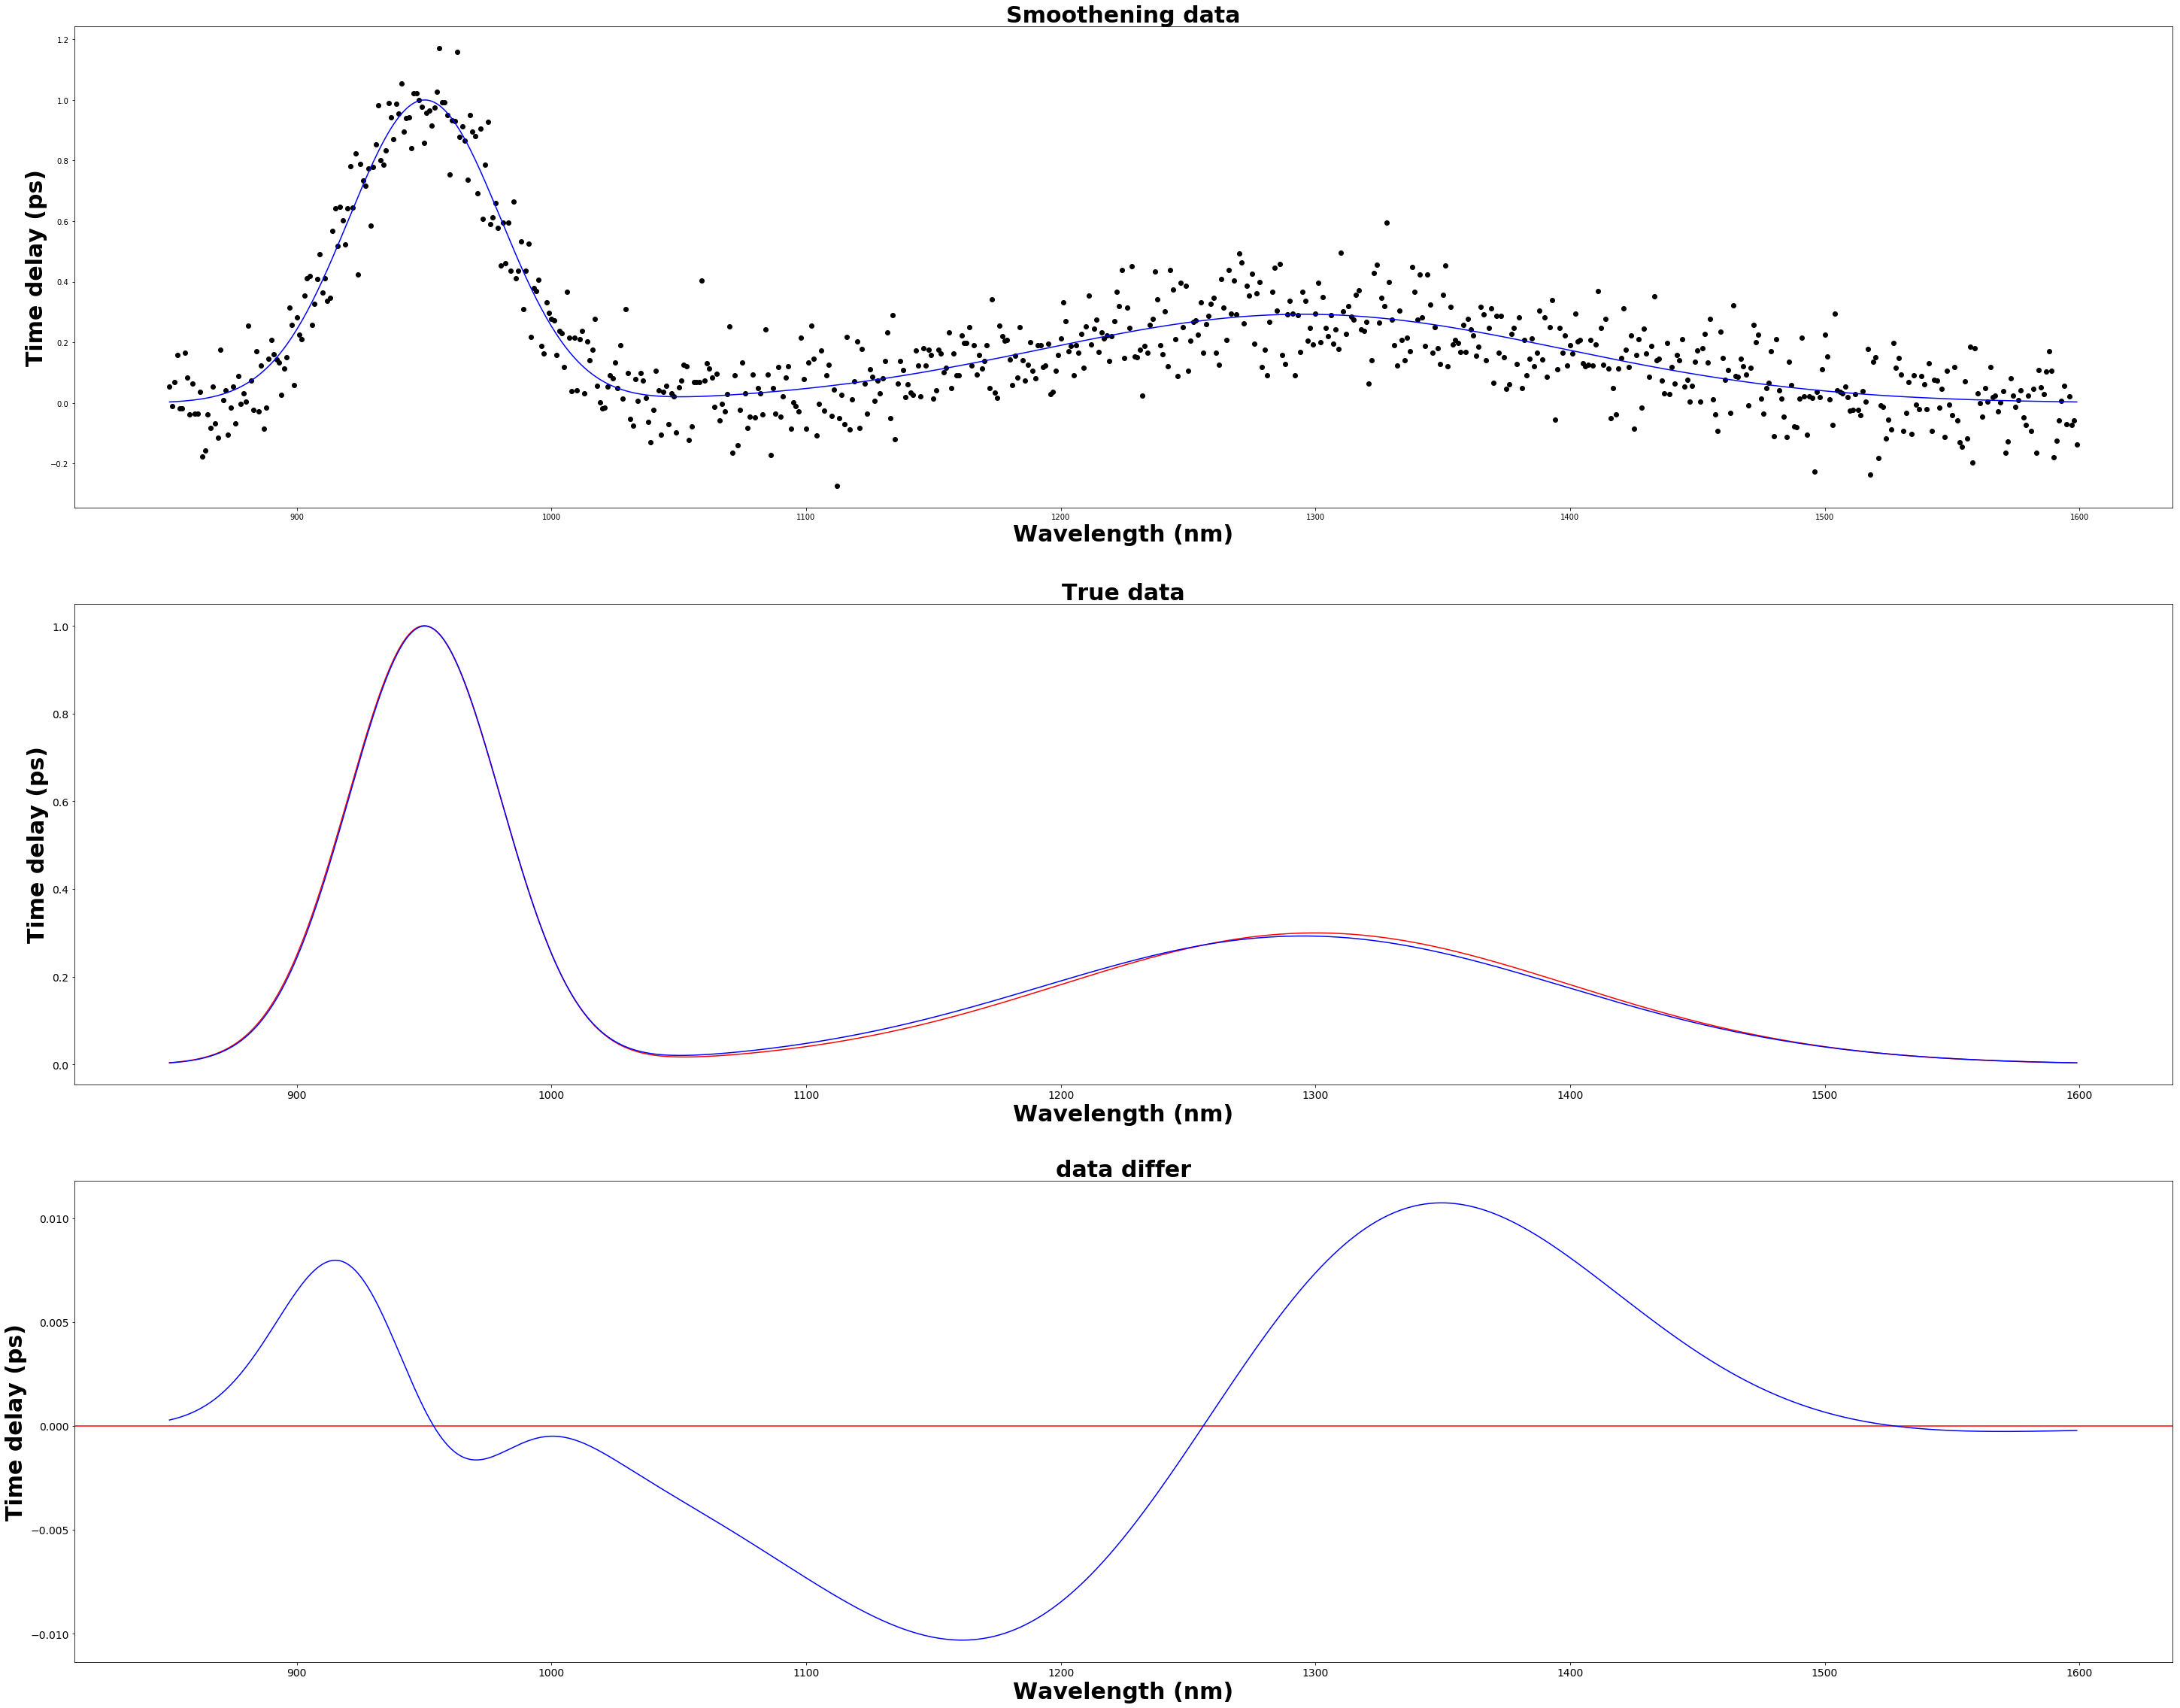

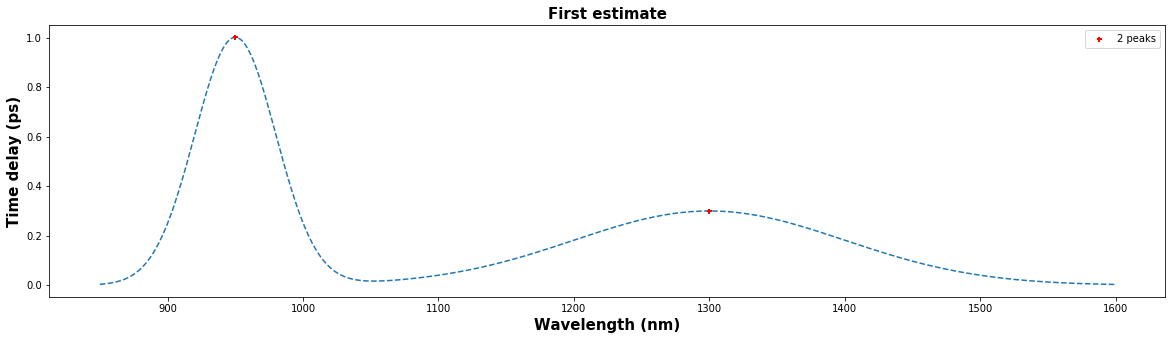

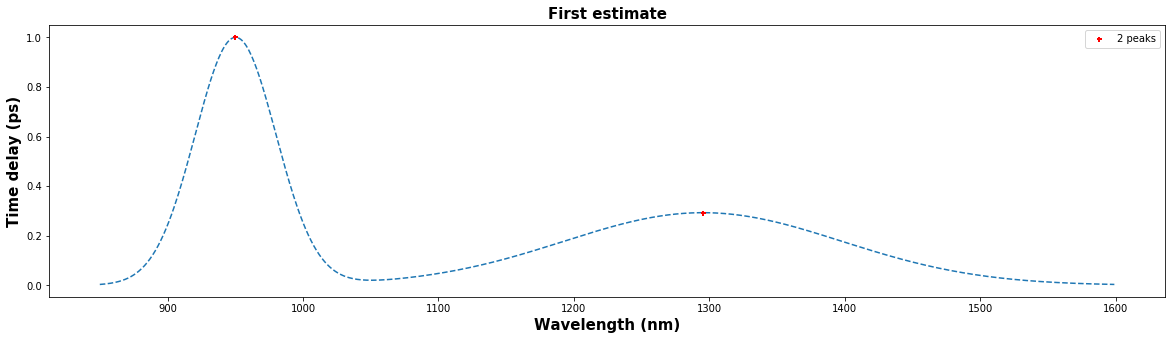

In [294]:
g1 = models.Gaussian1D(1, 950, 30)
g2 = models.Gaussian1D(0.3, 1300, 100)
gg_init = g1+g2

nm_array = syntheticdata.nm
timedelay = (syntheticdata.species_1 + syntheticdata.species_2)
noise_coefficient =0.1
ysmooth1 = astropy_smoothing(nm_array, timedelay, noise_coefficient,gg_init)
peak_finding(nm_array,timedelay)
peak_finding(nm_array,ysmooth1)

## three gaussian

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.206937234894852
            Iterations: 51
            Function evaluations: 569
            Gradient evaluations: 51
[101 256 446]
[ 951 1106 1296] [1.02302416 0.54320229 0.30216871]
[101 256 434]
[ 951 1106 1284] [1.02507569 0.54015065 0.29488449]


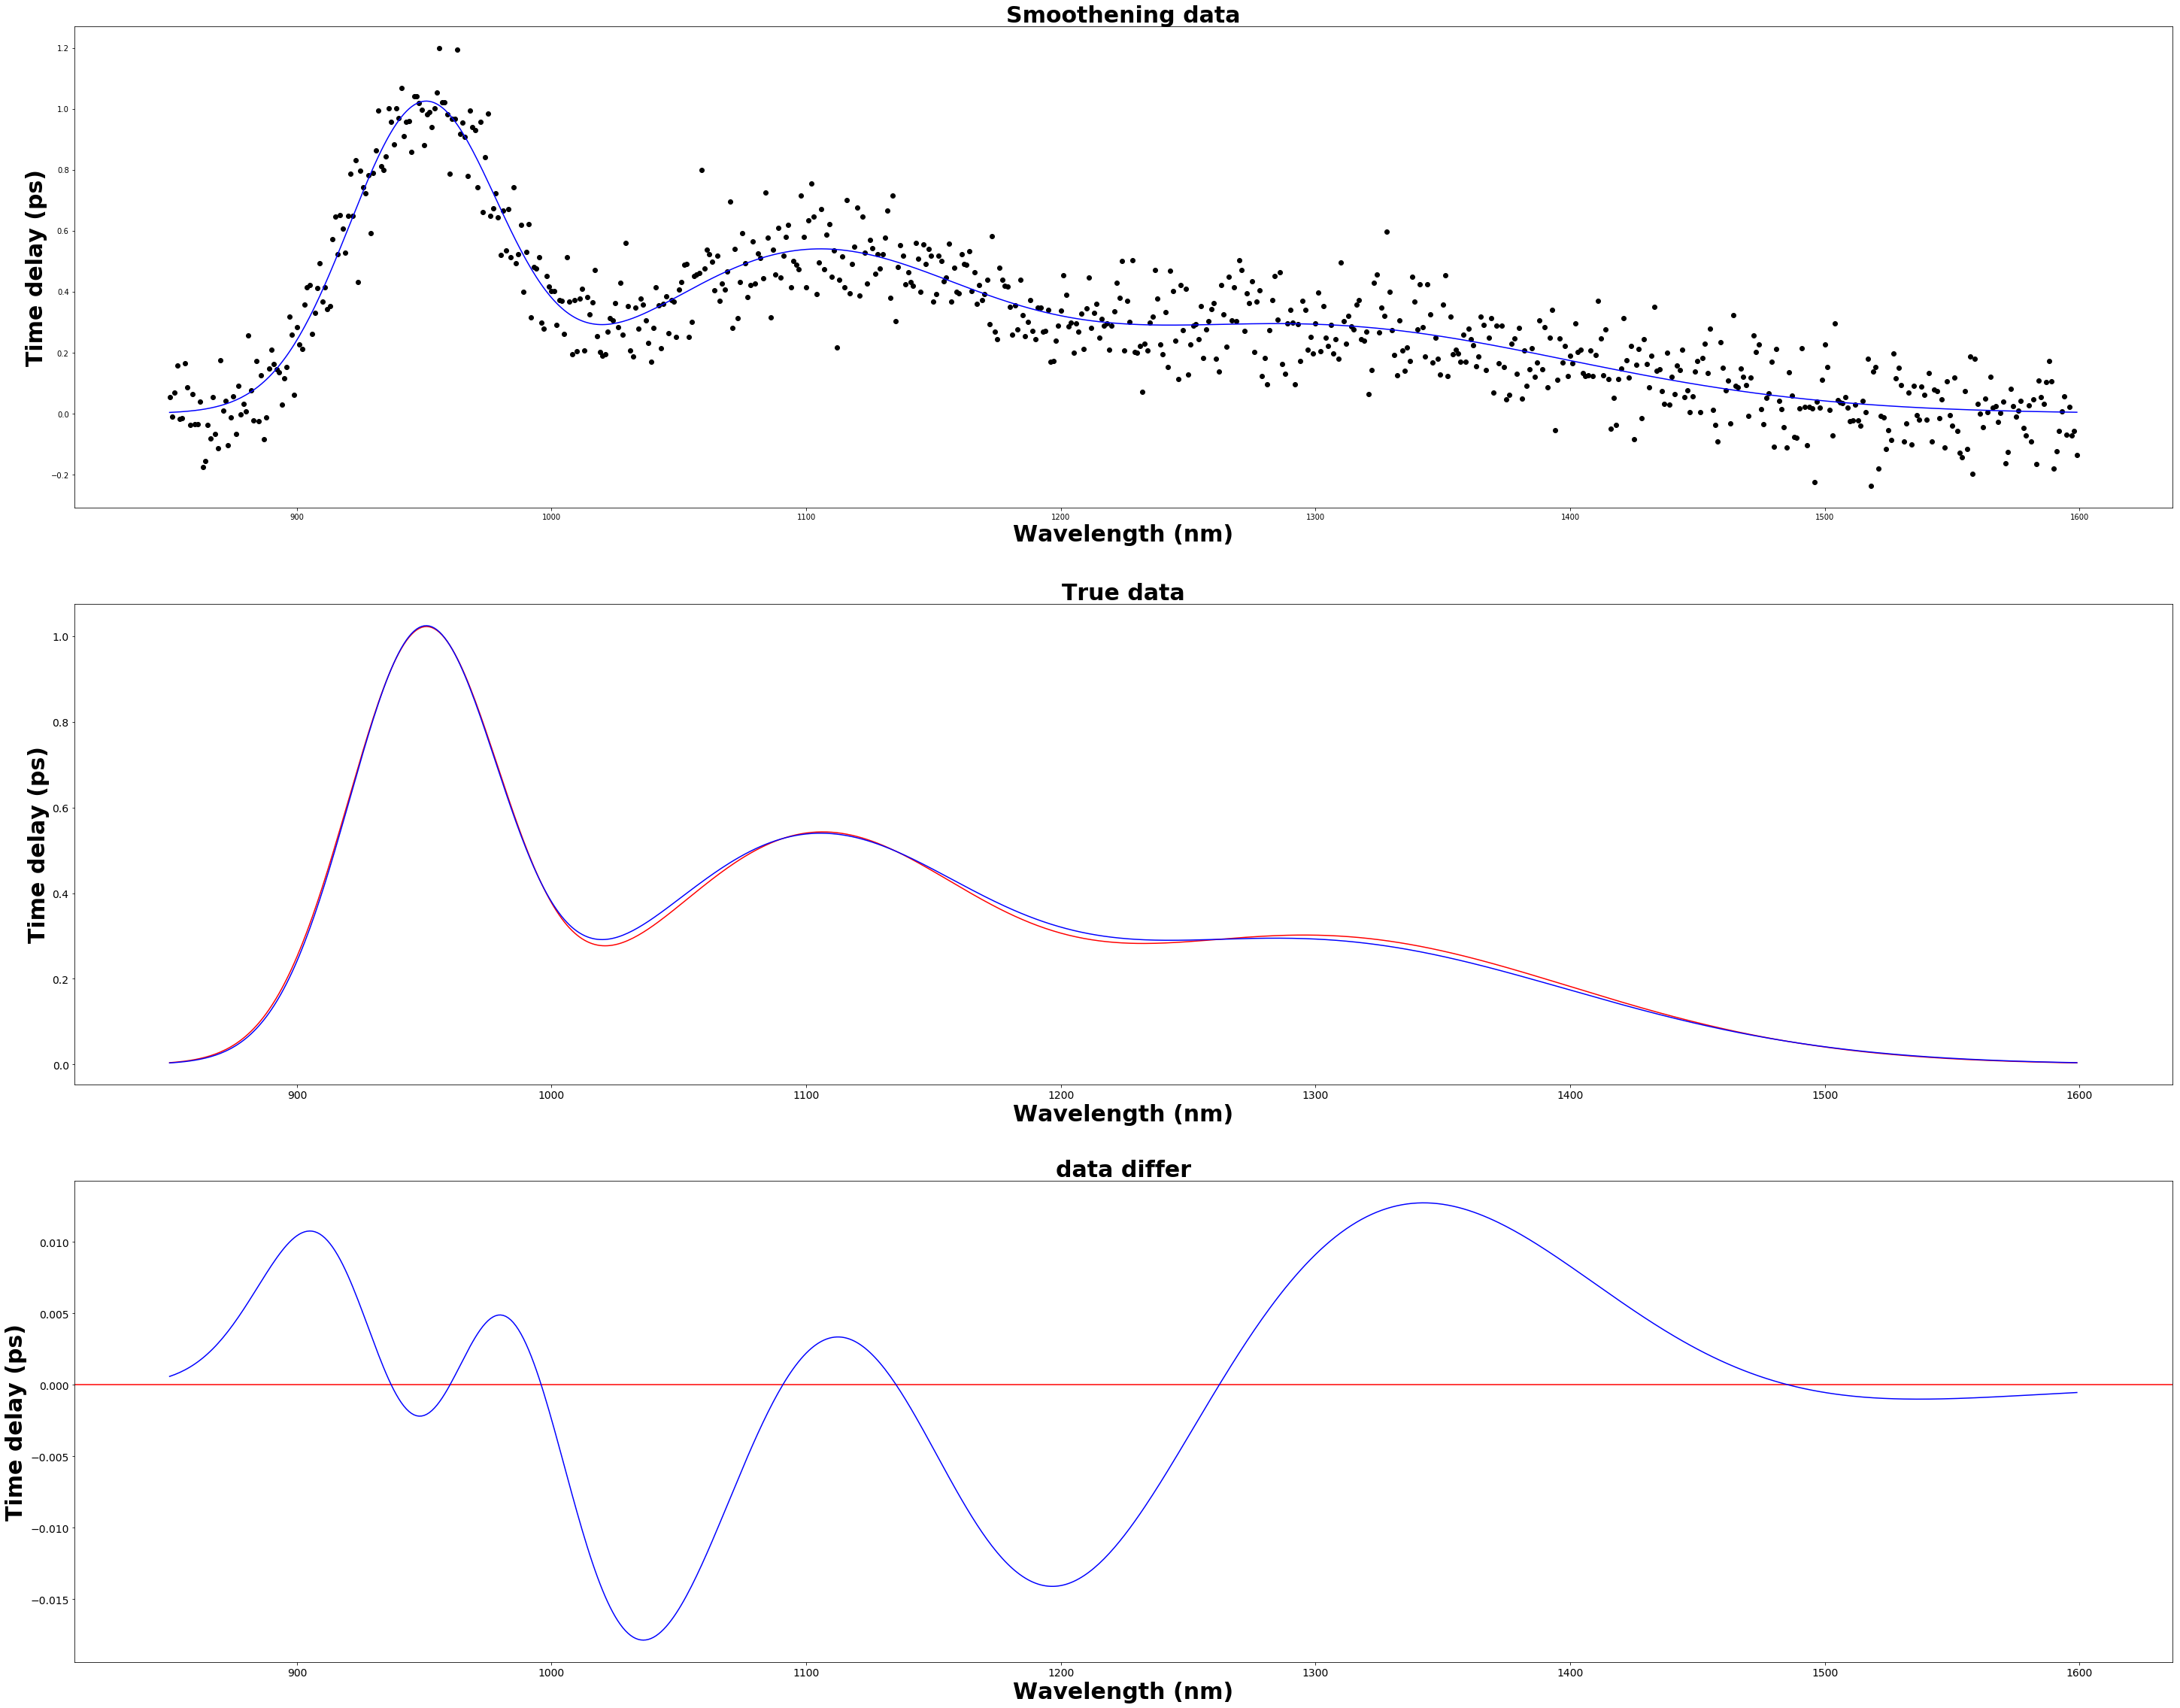

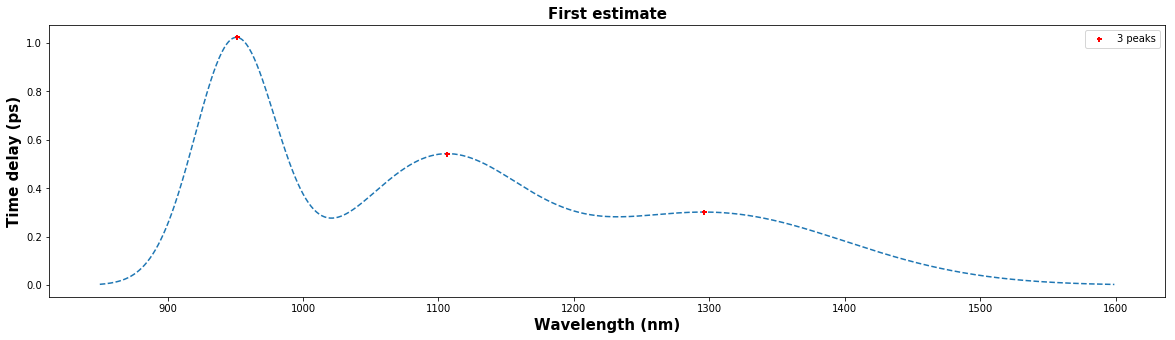

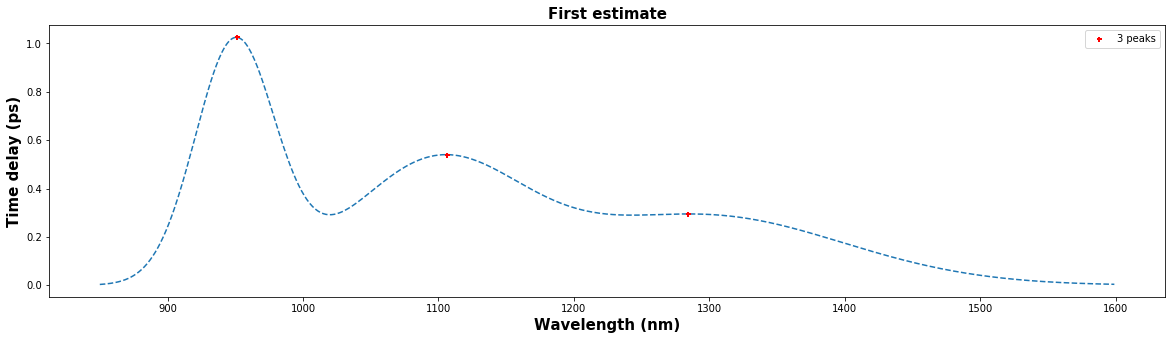

In [295]:
g1 = models.Gaussian1D(1, 950, 30)
g2 = models.Gaussian1D(0.3, 1300, 100)
g3 = models.Gaussian1D(0.5, 1100, 60)
gg_init = g1+g2+g3

nm_array = threegaussians.nm
timedelay = (threegaussians.species_1 + threegaussians.species_2 + threegaussians.species_3)
noise_coefficient =0.1
ysmooth2=astropy_smoothing(nm_array, timedelay, noise_coefficient,gg_init)
peak_finding(nm_array,timedelay)
peak_finding(nm_array,ysmooth2)

## one lorentzian

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.07248808125569868
            Iterations: 28
            Function evaluations: 142
            Gradient evaluations: 28
[100]
[950] [0.03333333]
[101]
[951] [0.03274046]


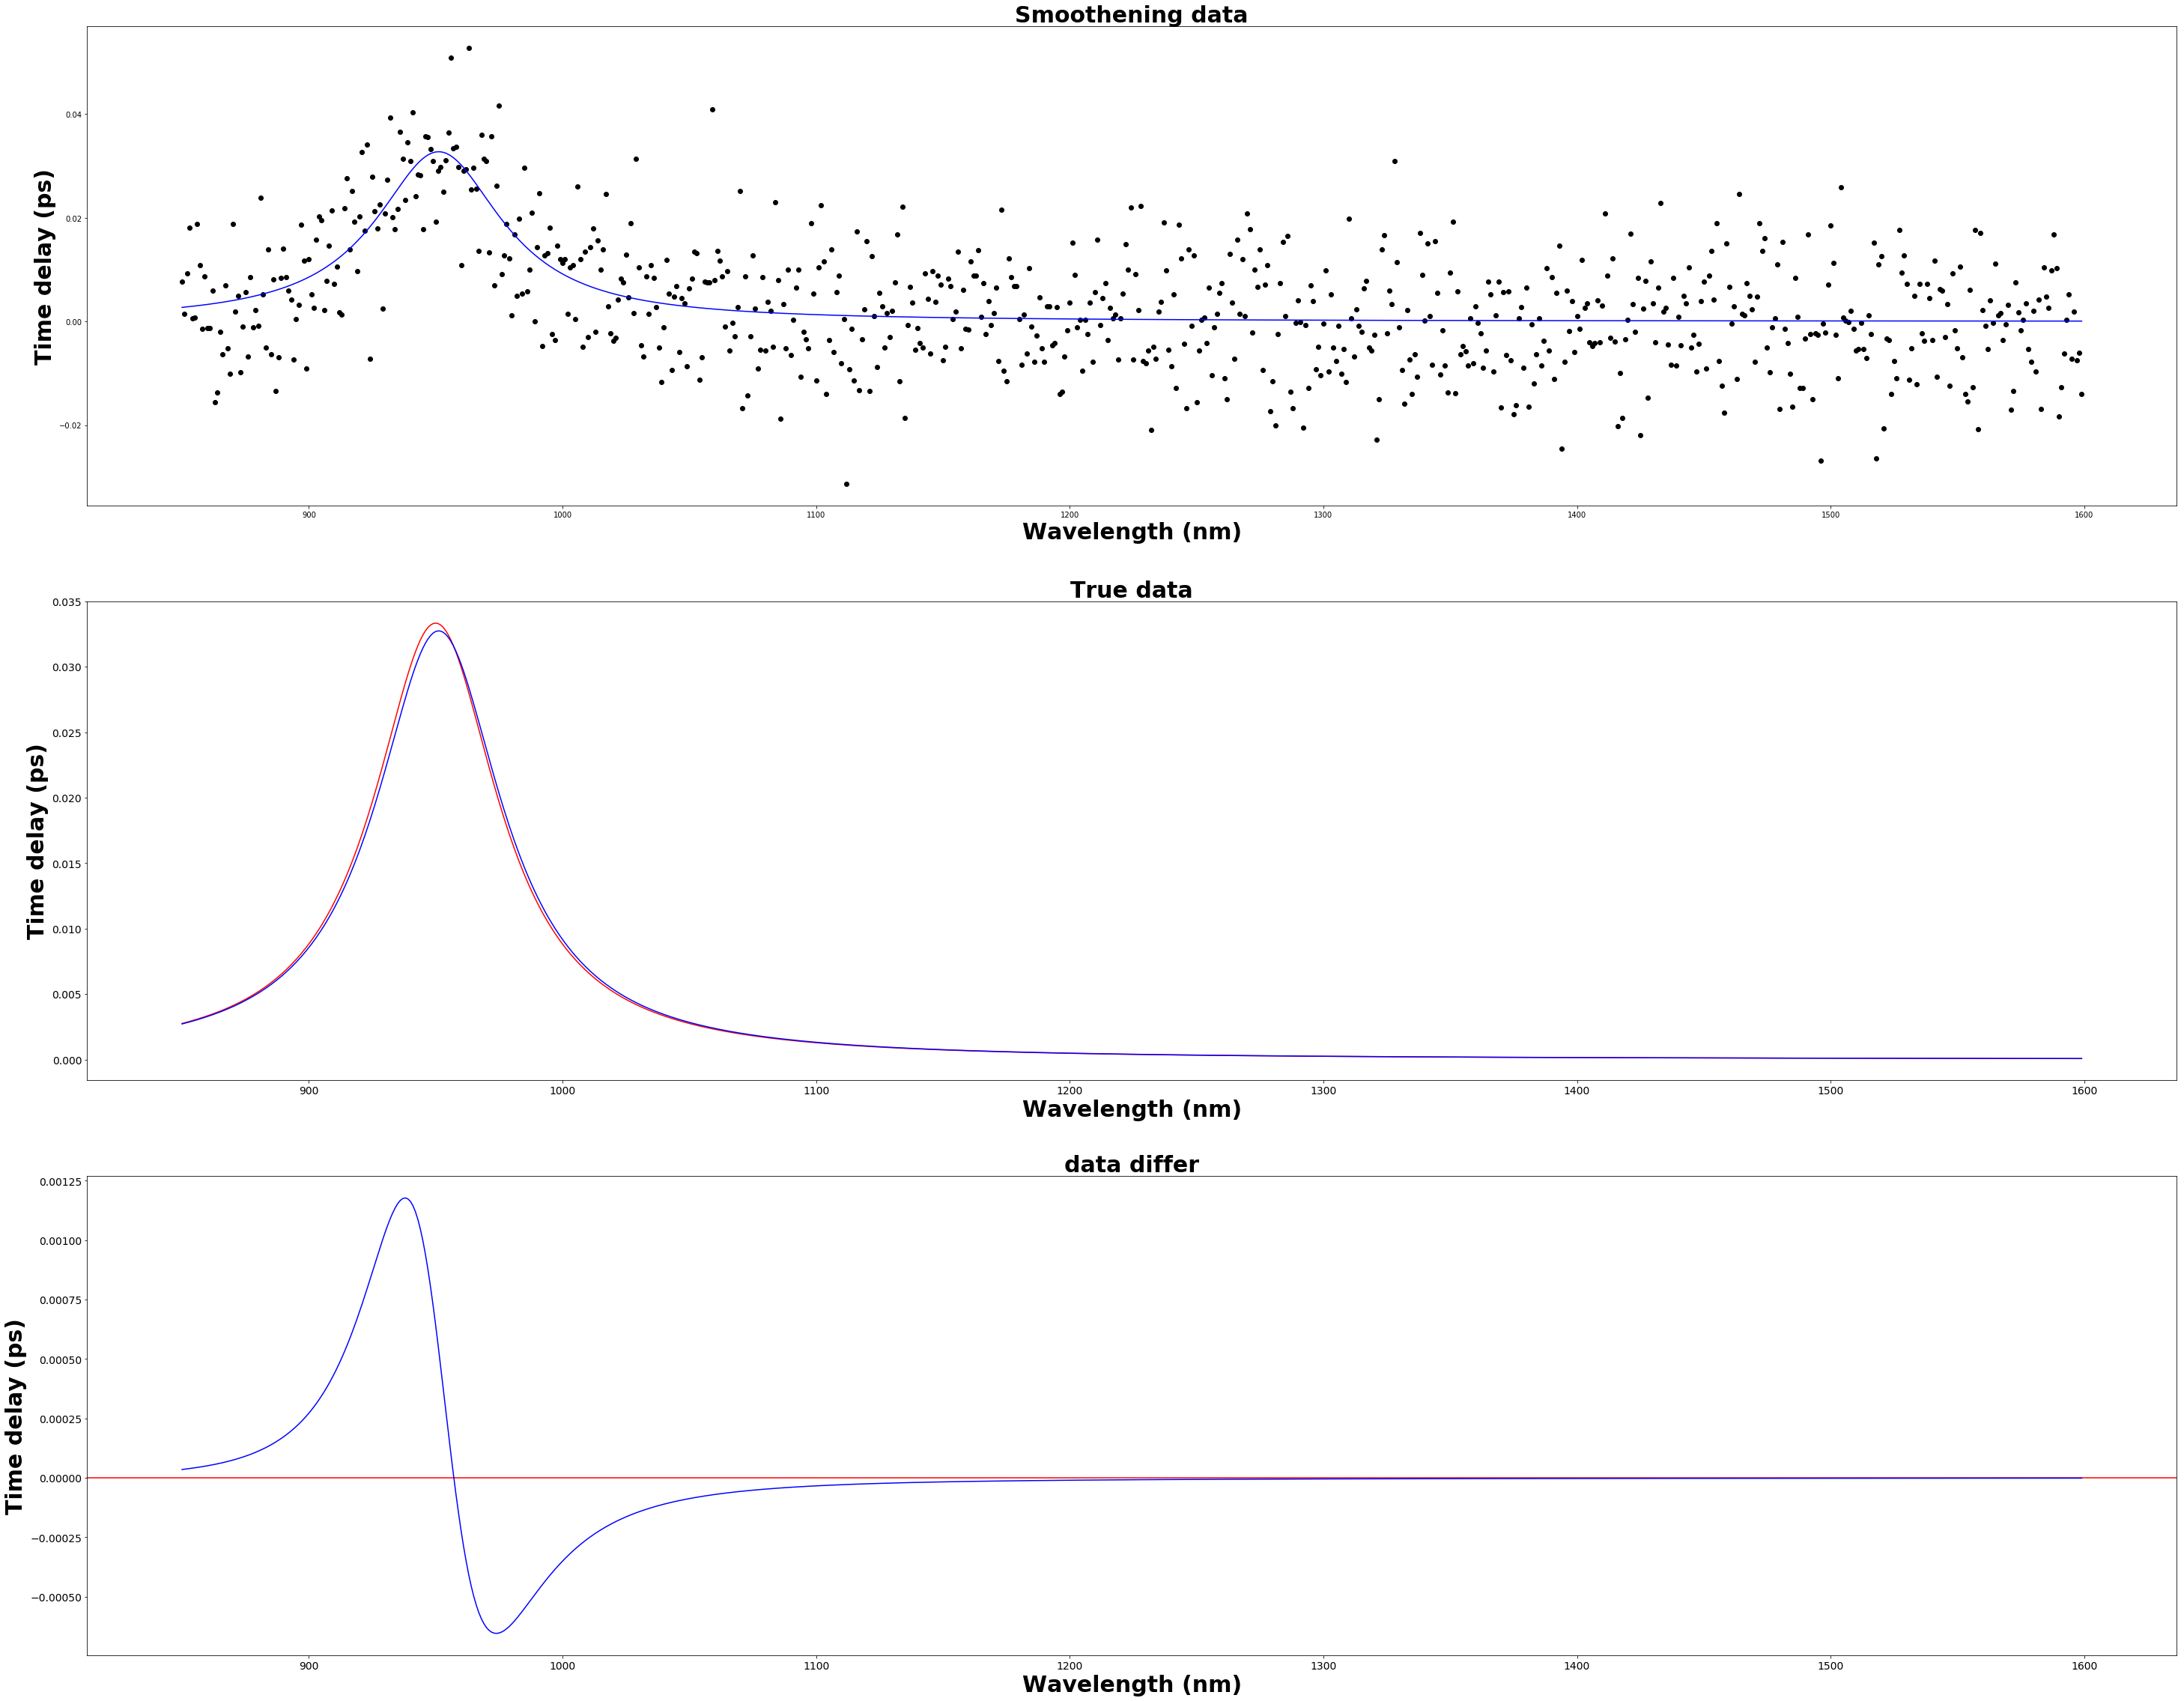

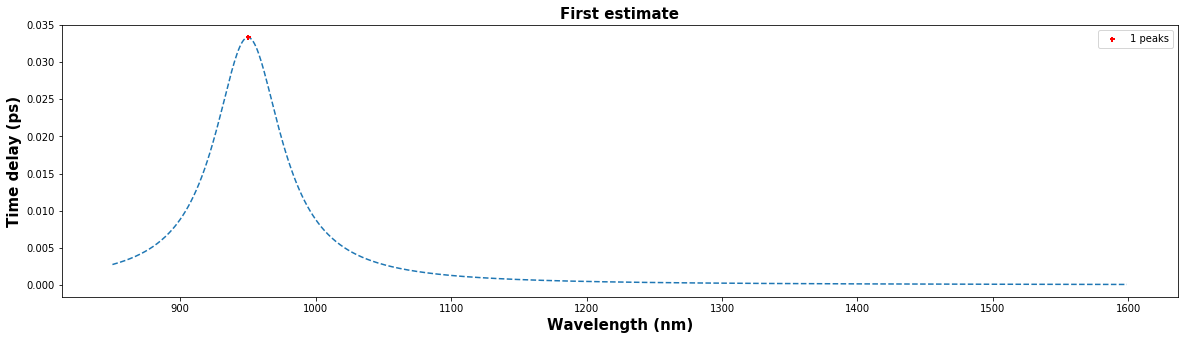

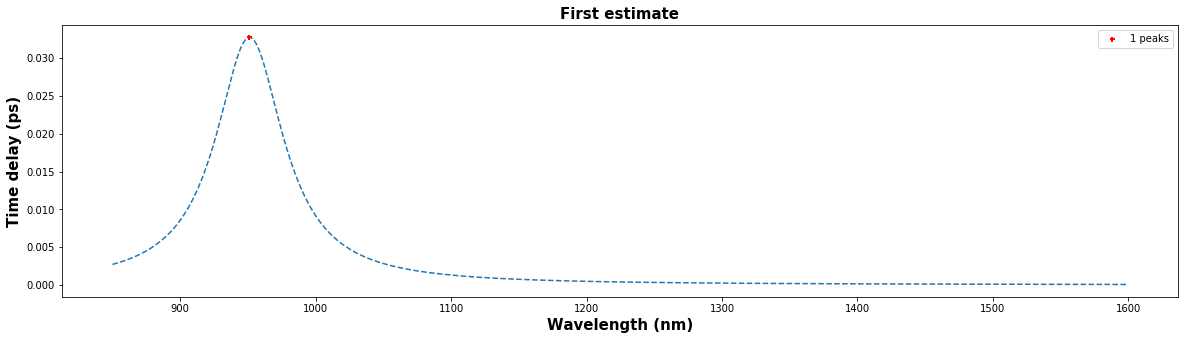

In [280]:
g1 = models.Lorentz1D(1, 950, 30)
gg_init = g1
nm_array = lorentzian.nm
timedelay = lorentzian.species_1 
noise_coefficient =0.01
ysmooth=astropy_smoothing(nm_array, timedelay, noise_coefficient,gg_init)
peak_finding(nm_array,timedelay)
peak_finding(nm_array,ysmooth)

## two lorentzian

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.07265763459572522
            Iterations: 26
            Function evaluations: 212
            Gradient evaluations: 26
[100 448]
[ 950 1298] [0.03355975 0.00324469]
[101 448]
[ 951 1298] [0.03274445 0.00345709]


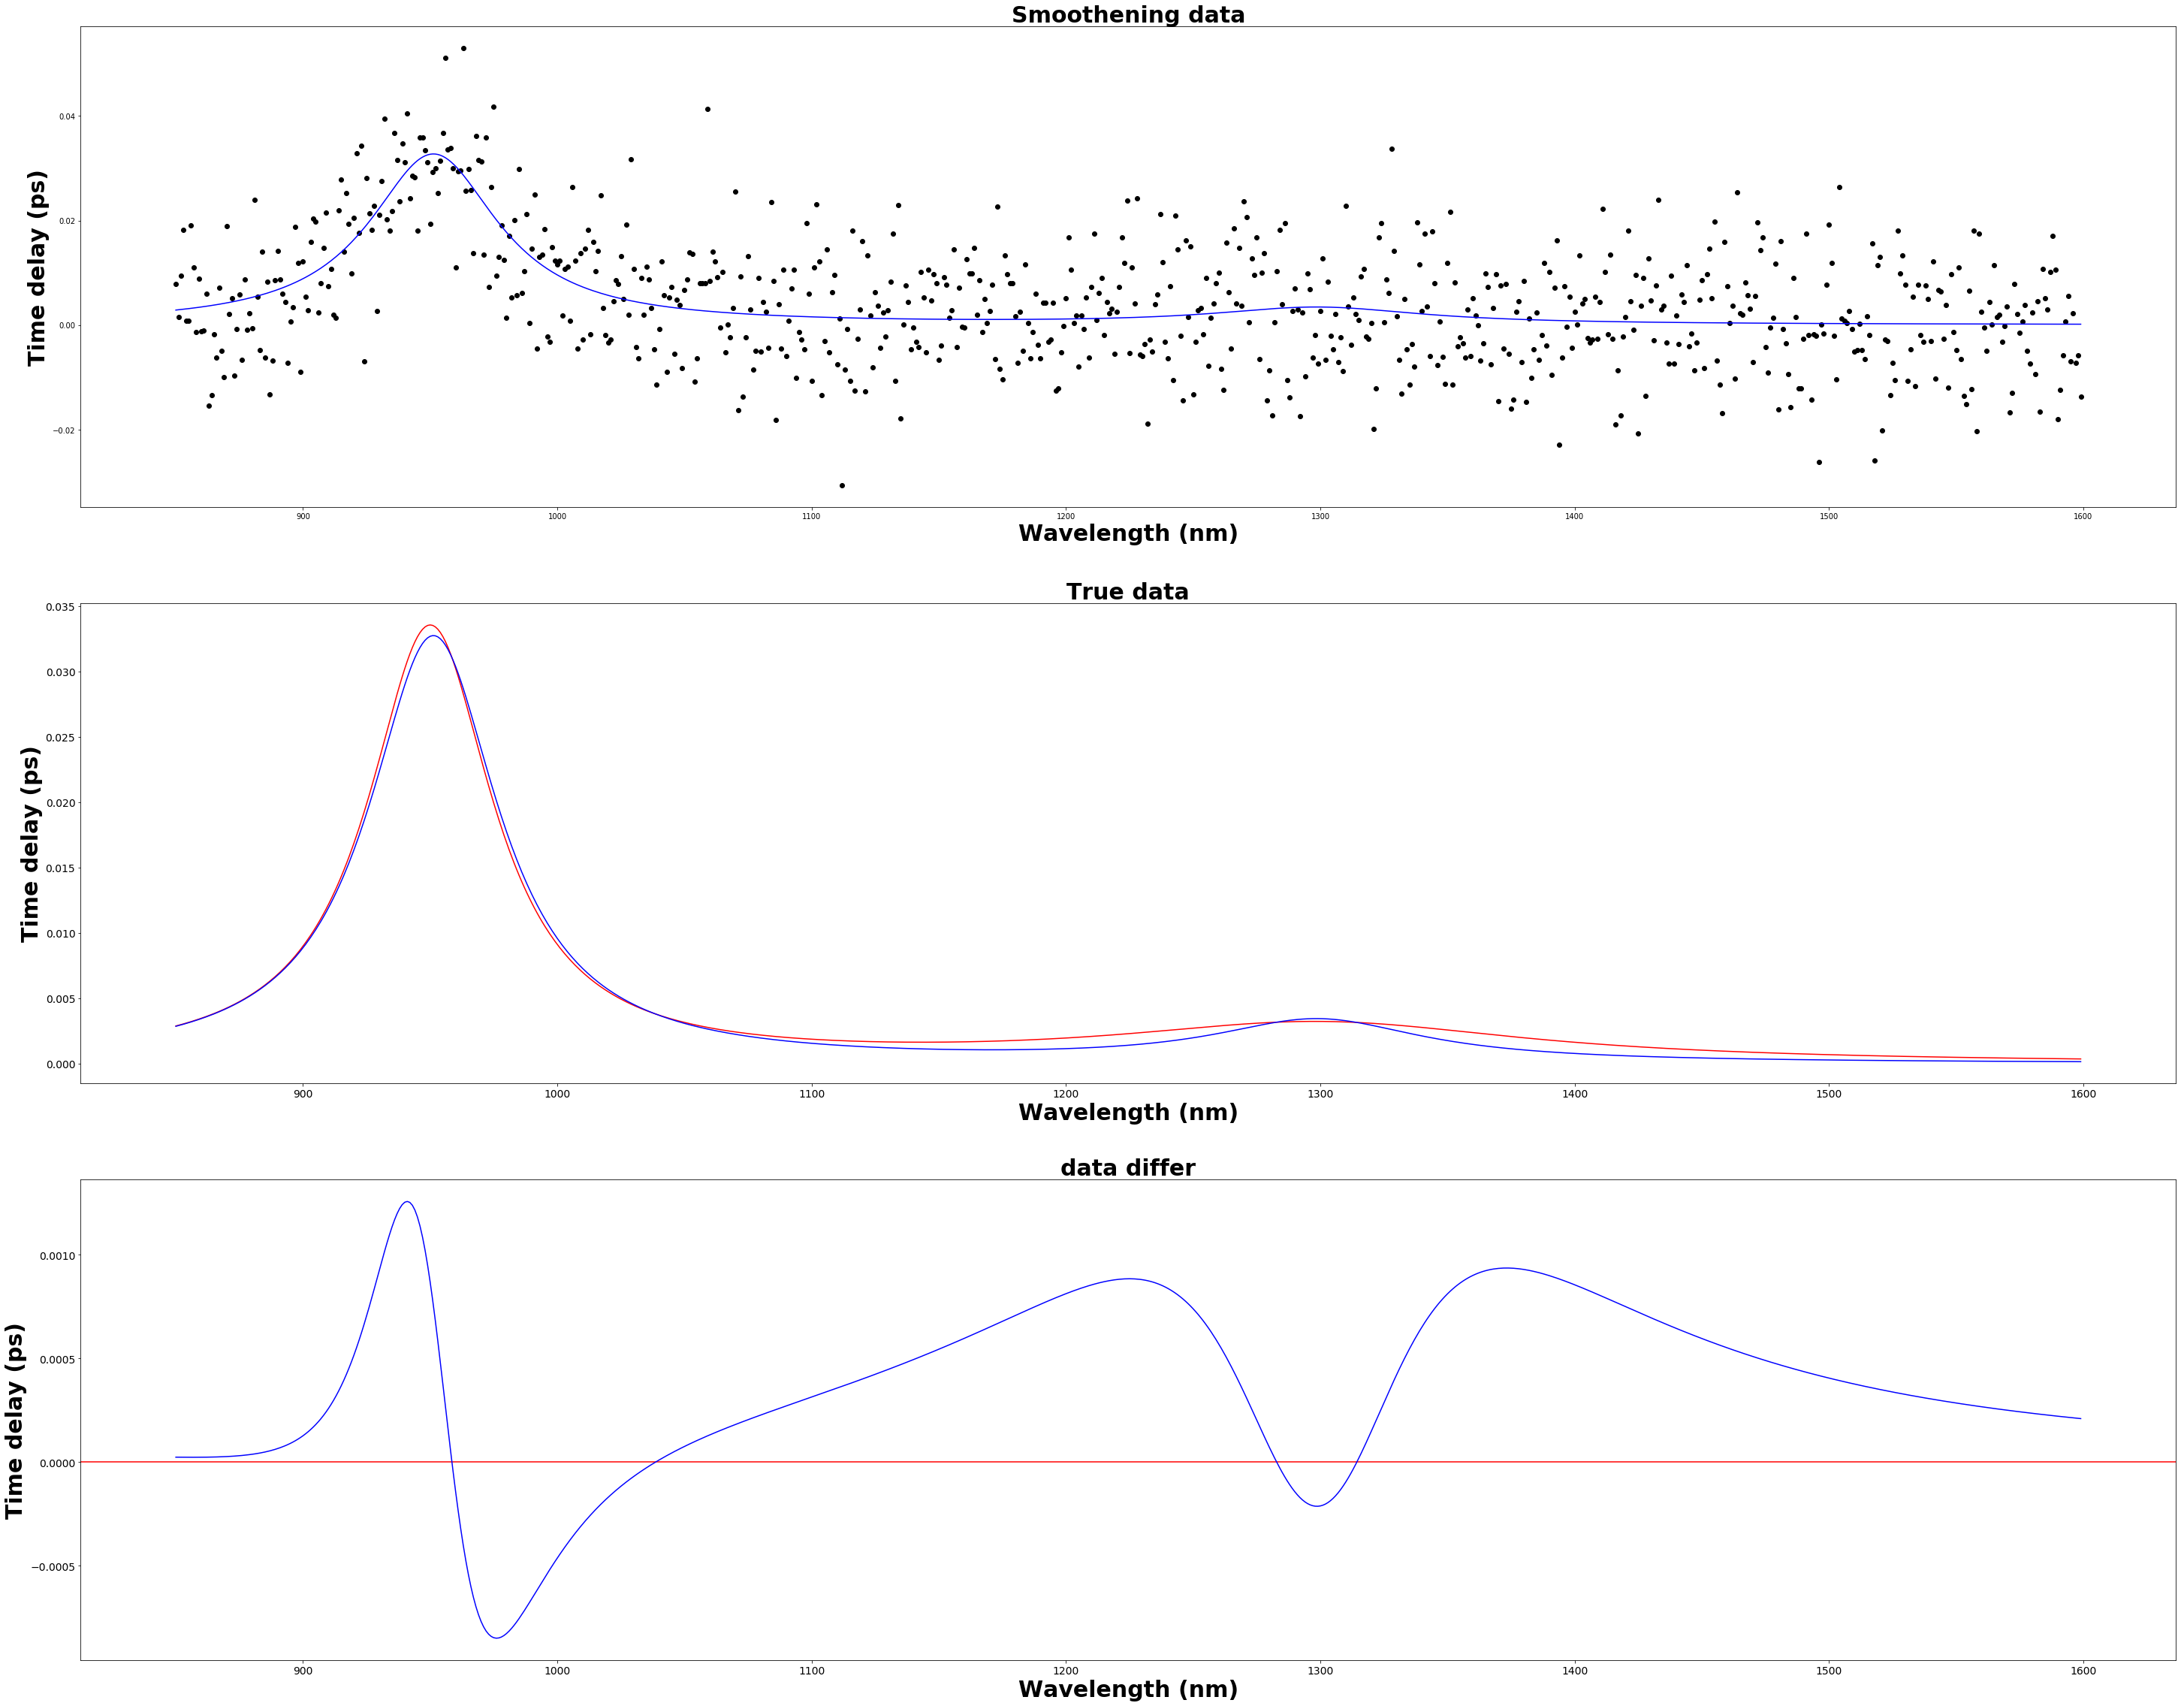

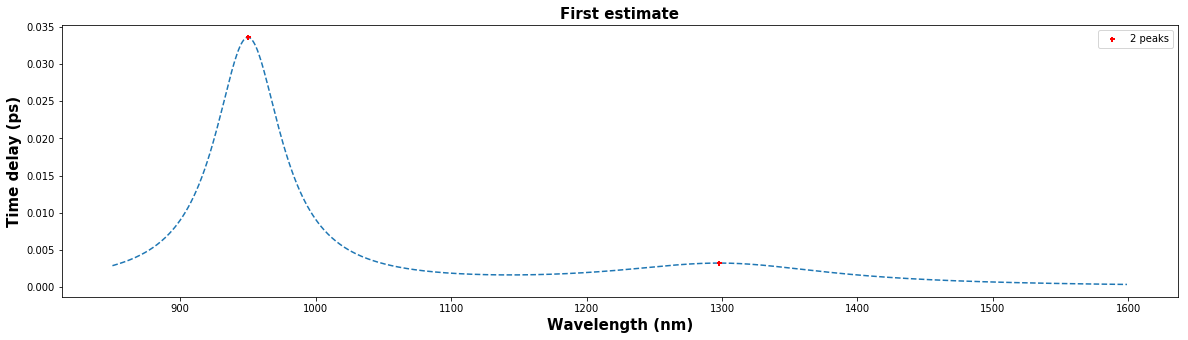

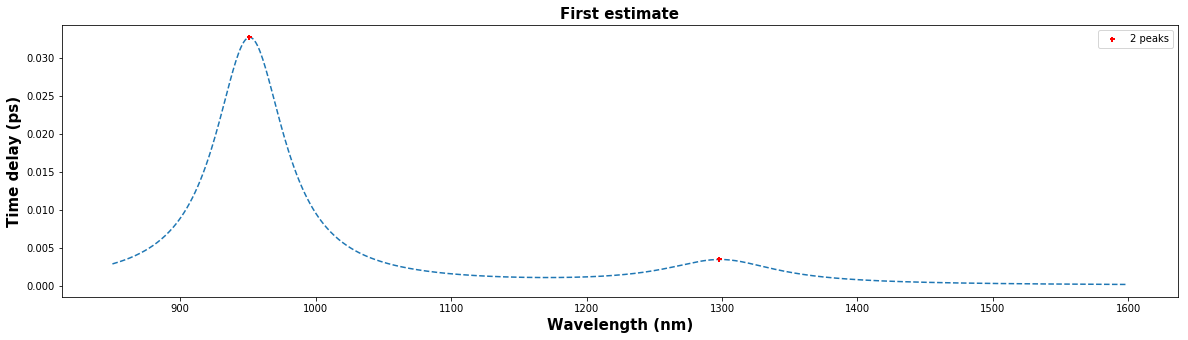

In [296]:
g1 = models.Lorentz1D(1, 950, 30)
g2 = models.Lorentz1D(0.3, 1300, 100)
gg_init = g1+g2

nm_array = lorentzian.nm
timedelay = lorentzian.species_1+lorentzian.species_2
noise_coefficient =0.01
ysmooth3=astropy_smoothing(nm_array, timedelay, noise_coefficient,gg_init)
peak_finding(nm_array,timedelay)
peak_finding(nm_array,ysmooth3)

# Find a good peak-finding function-- Plotly function!

In [289]:
import plotly
plotly.tools.set_credentials_file(username='tujing', api_key='NXQwAGUWN2VK4U3rCrqO')

In [297]:

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import numpy as np
import pandas as pd
import scipy
import peakutils

time_series=ysmooth1
cb = np.array(time_series)
indices = peakutils.indexes(cb, thres=0.02/max(cb), min_dist=0.1)

trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace, trace2]
py.iplot(data, filename='milk-production-plot-with-higher-peaks')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tujing/0 or inside your plot.ly account where it is named 'milk-production-plot-with-higher-peaks'


In [298]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import numpy as np
import pandas as pd
import scipy
import peakutils

time_series=ysmooth2
cb = np.array(time_series)
indices = peakutils.indexes(cb, thres=0.02/max(cb), min_dist=0.1)

trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace, trace2]
py.iplot(data, filename='milk-production-plot-with-higher-peaks')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tujing/0 or inside your plot.ly account where it is named 'milk-production-plot-with-higher-peaks'


In [301]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import numpy as np
import pandas as pd
import scipy
import peakutils

time_series=ysmooth3
cb = np.array(time_series)
indices = peakutils.indexes(cb, thres=0, min_dist=0.1)

trace = go.Scatter(
    x=[j for j in range(len(time_series))],
    y=time_series,
    mode='lines',
    name='Original Plot'
)

trace2 = go.Scatter(
    x=indices,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Detected Peaks'
)

data = [trace, trace2]
py.iplot(data, filename='milk-production-plot-with-higher-peaks')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tujing/0 or inside your plot.ly account where it is named 'milk-production-plot-with-higher-peaks'
